**ABSTRACT**

In the competitive world of credit cards, understanding customer behavior is key. Adobo Advantage Cards (AAC) collected a comprehensive dataset of credit card transactions. The dataset includes transaction details, customer demographics, and amounts spent in various categories.

Use this data to perform RFM analysis and K-means clustering. By segmenting customers, uncover valuable insights and discover spending patterns. Turn this data into actionable strategies to drive AAC's business growth.

# **Step 1: Import Libraries**

In [ ]:
# # Install (if necessary)
!pip install feature_engine
!pip install kneed

# Standard Data Tools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns

# ML Tools
from scipy import stats
from scipy.stats import norm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Utility Tools
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

# **Step 2: Data Cleaning and Preprocessing**

### **Load the dirty dataset**

In [ ]:
url = 'cc_dirty.csv'
df = pd.read_csv(url)

display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  float64
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  object 
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   111877 non-null  int64  
 7   acct_num2  111877 non-null  int64  
 8   trans_num  111877 non-null  object 
 9   unix_time  111877 non-null  int64  
 10  category   103318 non-null  object 
 11  amt        111877 non-null  object 
dtypes: float64(1), int64(3), object(8)
memory usage: 10.2+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,acct_num2,trans_num,unix_time,category,amt
0,6.760000e+11,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,798000000000,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3.520000e+15,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,968000000000,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4.140000e+18,Male,Calapan,"133,893 people",Financial controller,23/07/1953,628000000000,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4.870000e+15,M,San Fernando,"121,812 people",NaN,18/07/1964,863000000000,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4.720000e+15,M,Laoag,"111,125 people",Dance movement psychotherapist,11/01/1954,257000000000,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


### **Cleaning 1:** remove 'acct_num2' since it's just a duplicate of 'acct_num'

> The 'acct_num2' column was removed because it was identified as a duplicate of 'acct_num'. Keeping duplicates can lead to redundancy in the dataset and may skew analysis results.



In [ ]:
# Assign orig df to another df
df_cleaning1 = df

# Drop duplicate columns
df_cleaning1 = df_cleaning1.T.drop_duplicates().T

# Display the updated dataframe
display(df_cleaning1.info(), df_cleaning1.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cc_num     111877 non-null  object
 1   gender     111877 non-null  object
 2   city       111877 non-null  object
 3   city_pop   111877 non-null  object
 4   job        103427 non-null  object
 5   dob        111877 non-null  object
 6   acct_num   111877 non-null  object
 7   trans_num  111877 non-null  object
 8   unix_time  111877 non-null  object
 9   category   103318 non-null  object
 10  amt        111877 non-null  object
dtypes: object(11)
memory usage: 9.4+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,"659,019 people",Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3520000000000000.0,M,Digos,"169,393 people","Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4140000000000000000.0,Male,Calapan,"133,893 people",Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4870000000000000.0,M,San Fernando,"121,812 people",NaN,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4720000000000000.0,M,Laoag,"111,125 people",Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


### **Cleaning 2:** remove " people" in 'city_pop' and convert to numeric

> The 'city_pop' column had the string " people" in it, which was removed to convert it to a numeric format. This was done to ensure that the column could be used for numerical analysis, as numeric data is more versatile for statistical calculations and modeling.

In [ ]:
# CLEANING 2: remove " people" in 'city_pop' and convert to numeric

# Assign previous df to another df
df_cleaning2 = df_cleaning1

# Use astype() to cast a pandas object to a specified data type
df_cleaning2['city_pop'] = df_cleaning2['city_pop'].astype(str)

# Remove "people" in 'city_pop'
df_cleaning2['city_pop'] = df_cleaning2['city_pop'].str.replace(' people', '').str.replace(',', '')

# Convert 'city_pop 'to numeric
df_cleaning2['city_pop'] = pd.to_numeric(df_cleaning2['city_pop'])

# Display the updated dataframe
display(df_cleaning2.info(), df_cleaning2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cc_num     111877 non-null  object
 1   gender     111877 non-null  object
 2   city       111877 non-null  object
 3   city_pop   111877 non-null  int64 
 4   job        103427 non-null  object
 5   dob        111877 non-null  object
 6   acct_num   111877 non-null  object
 7   trans_num  111877 non-null  object
 8   unix_time  111877 non-null  object
 9   category   103318 non-null  object
 10  amt        111877 non-null  object
dtypes: int64(1), object(10)
memory usage: 9.4+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4140000000000000000.0,Male,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4870000000000000.0,M,San Fernando,121812,NaN,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


### **Cleaning 3:** use M/F instead of Male/Female in 'gender'

> The 'gender' column originally used "Male" and "Female" values, which were updated to "M" and "F" for brevity and consistency. This change simplifies data entry and ensures that all gender values are represented consistently.



In [ ]:
# CLEANING 3: use M/F instead of Male/Female in 'gender'

# Assign previous df to another df
df_cleaning3 = df_cleaning2

# Define a dictionary gender-mapping of old values to new values
gender_mapping = {'Male': 'M', 'Female': 'F'}

# Change values under 'gender' using .replace()
df_cleaning3['gender'] = df_cleaning3['gender'].replace(gender_mapping)

# Display the updated dataframe
display(df_cleaning3.info(), df_cleaning3.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   cc_num     111877 non-null  object
 1   gender     111877 non-null  object
 2   city       111877 non-null  object
 3   city_pop   111877 non-null  int64 
 4   job        103427 non-null  object
 5   dob        111877 non-null  object
 6   acct_num   111877 non-null  object
 7   trans_num  111877 non-null  object
 8   unix_time  111877 non-null  object
 9   category   103318 non-null  object
 10  amt        111877 non-null  object
dtypes: int64(1), object(10)
memory usage: 9.4+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,$68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,$50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,$105.44
3,4870000000000000.0,M,San Fernando,121812,NaN,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,$38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,$82.69


### **Cleaning 4:** remove "$" in 'amt' and convert to numeric

> The '$' symbol was removed from the 'amt' column, and the column was converted to a numeric data type. This transformation allows for numerical analysis and calculations involving transaction amounts.



In [ ]:
# CLEANING 4: remove "$" in 'amt' and convert to numeric

# Assign previous df to another df
df_cleaning4 = df_cleaning3

# Use astype() to cast a pandas object to a specified data type
df_cleaning4['amt'] = df_cleaning4['amt'].astype(str)

# Remove "$" in 'amt'
df_cleaning4['amt'] = df_cleaning4['amt'].str.replace('$', '')

# Convert 'amt' to numeric
df_cleaning4['amt'] = pd.to_numeric(df_cleaning4['amt'])

# Display the updated dataframe
display(df_cleaning4.info(), df_cleaning4.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111877 entries, 0 to 111876
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     111877 non-null  object 
 1   gender     111877 non-null  object 
 2   city       111877 non-null  object 
 3   city_pop   111877 non-null  int64  
 4   job        103427 non-null  object 
 5   dob        111877 non-null  object 
 6   acct_num   111877 non-null  object 
 7   trans_num  111877 non-null  object 
 8   unix_time  111877 non-null  object 
 9   category   103318 non-null  object 
 10  amt        111877 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 9.4+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,NaN,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69


### **Cleaning 5:** remove duplicates in 'trans_num'

> Duplicate entries in the 'trans_num' column were removed. Duplicate data can lead to skewed analysis and inaccurate insights, so it's essential to eliminate such duplicates.



In [ ]:
# CLEANING 5: remove duplicates in 'trans_num'

# Assign previous df to another df
df_cleaning5 = df_cleaning4

# Assign duplicates to another df
duplicate_values = df_cleaning5['trans_num'].duplicated()

# Print the number of duplicates
print("Number of duplicates: ", duplicate_values.sum(), "\n")

# Drop duplicate rows
df_cleaning5 = df_cleaning5.drop_duplicates(subset=['trans_num'], keep='first')

# Display the updated dataframe
display(df_cleaning5.info(), df_cleaning5.head())

Number of duplicates:  11877 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     100000 non-null  object 
 1   gender     100000 non-null  object 
 2   city       100000 non-null  object 
 3   city_pop   100000 non-null  int64  
 4   job        92432 non-null   object 
 5   dob        100000 non-null  object 
 6   acct_num   100000 non-null  object 
 7   trans_num  100000 non-null  object 
 8   unix_time  100000 non-null  object 
 9   category   92392 non-null   object 
 10  amt        100000 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 9.2+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,NaN,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69


### **Cleaning 6:** remove "City" and "City of " in 'city'

> The 'city' column had variations like "City" and "City of " in some city names. These variations were removed to standardize city names and make them more consistent for analysis purposes.



In [ ]:
# CLEANING 6: remove "City" and "City of" in 'city'

# Assign previous df to another df
df_cleaning6 = df_cleaning5

# Remove " City" and "City of "
df_cleaning6['city'] = df_cleaning6['city'].str.replace('City of ', '').str.replace(' City', '')

# Check if " City" and "City of " are removed
display(df_cleaning6['city'].unique())

# Display the updated dataframe
display(df_cleaning6.info(), df_cleaning6.head())

array(['Dasmarinas', 'Digos', 'Calapan', 'San Fernando', 'Laoag',
       'Paranaque', 'Balanga', 'Masbate', 'Malaybalay', 'Antipolo',
       'General Santos', 'Navotas', 'Marikina', 'Malabon', 'Palayan',
       'Naga', 'Binan', 'Vigan', 'Mati', 'Cadiz', 'Tacloban', 'Dagupan',
       'Isabela', 'Cebu', 'Batangas', 'Meycauayan', 'Muntinlupa',
       'Olongapo', 'Sorsogon', 'Makati', 'Angeles', 'Calamba', 'Pagadian',
       'Tagbilaran', 'Dumaguete', 'Santa Rosa', 'Butuan', 'San Pedro',
       'Tuguegarao', 'Valenzuela', 'Cabanatuan', 'Maasin', 'Santiago',
       'Manila', 'Lipa', 'Puerto Princesa', 'Caloocan',
       'San Jose del Monte', 'Imus', 'San Juan', 'Dipolog', 'Legazpi',
       'Surigao', 'Iligan', 'Talisay', 'Bacolod', 'Mandaluyong', 'Iloilo',
       'Lucena'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     100000 non-null  object 
 1   gender     100000 non-null  object 
 2   city       100000 non-null  object 
 3   city_pop   100000 non-null  int64  
 4   job        92432 non-null   object 
 5   dob        100000 non-null  object 
 6   acct_num   100000 non-null  object 
 7   trans_num  100000 non-null  object 
 8   unix_time  100000 non-null  object 
 9   category   92392 non-null   object 
 10  amt        100000 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 9.2+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,NaN,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69


### **Cleaning 7:** fill null values in 'job' and 'category' with "N/A"

> Null values in the 'job' and 'category' columns were filled with "N/A." This decision ensures that these columns contain consistent data throughout the dataset and prevents potential issues during analysis.



In [ ]:
# Identify missing values...count the nulls in each column
print("Missing Values")
display(df_cleaning6.isna().sum(axis=0))

Missing Values


cc_num          0
gender          0
city            0
city_pop        0
job          7568
dob             0
acct_num        0
trans_num       0
unix_time       0
category     7608
amt             0
dtype: int64

In [ ]:
# CLEANING 7: fill null values in 'job' and 'category' with "N/A"

# Assign previous df to another df
df_cleaning7 = df_cleaning6

# Drop null values and reset index after
df_cleaning7 = df_cleaning7.fillna({'job':'N/A', 'category':'N/A'})

# Display the updated dataframe
display(df_cleaning7.info(), df_cleaning7.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   cc_num     100000 non-null  object 
 1   gender     100000 non-null  object 
 2   city       100000 non-null  object 
 3   city_pop   100000 non-null  int64  
 4   job        100000 non-null  object 
 5   dob        100000 non-null  object 
 6   acct_num   100000 non-null  object 
 7   trans_num  100000 non-null  object 
 8   unix_time  100000 non-null  object 
 9   category   100000 non-null  object 
 10  amt        100000 non-null  float64
dtypes: float64(1), int64(1), object(9)
memory usage: 9.2+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,12/12/1958,798000000000,a72eaa86b043eed95b25bbb25b3153a1,1581314011,shopping_net,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",31/08/1970,968000000000,060d12f91c13871a13963041736a4702,1590902968,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,23/07/1953,628000000000,18aafb6098ab0923886c0ac83592ef8d,1585461157,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,N/A,18/07/1964,863000000000,45bbe714e51ab8a375454d39a190b0cb,1613063704,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,11/01/1954,257000000000,c20ee88b451f637bc6893b7460e9fee0,1601282159,gas_transport,82.69


### **Cleaning 8:** convert dtype of 'dob' and 'unix_time' to datetime

> The data types for 'dob' (date of birth) and 'unix_time' columns were converted to datetime. This conversion allows for date-based calculations and ensures that these columns are correctly interpreted as dates rather than strings or numbers.

In [ ]:
# CLEANING 8: convert dtype of 'dob' and 'unix_time' to datetime

# Assign previous df to another df
df_cleaning8 = df_cleaning7

# Convert dtype of 'dob' and 'unix_time' to datetime
df_cleaning8['dob'] = pd.to_datetime(df_cleaning8['dob'])
df_cleaning8['unix_time'] = pd.to_datetime(df_cleaning8['unix_time'], unit='s')

# Display the updated dataframe
display(df_cleaning8.info(), df_cleaning8.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     100000 non-null  object        
 1   gender     100000 non-null  object        
 2   city       100000 non-null  object        
 3   city_pop   100000 non-null  int64         
 4   job        100000 non-null  object        
 5   dob        100000 non-null  datetime64[ns]
 6   acct_num   100000 non-null  object        
 7   trans_num  100000 non-null  object        
 8   unix_time  100000 non-null  datetime64[ns]
 9   category   100000 non-null  object        
 10  amt        100000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 9.2+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping_net,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,968000000000,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,1953-07-23,628000000000,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,N/A,1964-07-18,863000000000,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,1954-11-01,257000000000,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69


#### In summary, these data cleaning decisions and actions were made to enhance the quality of the dataset by removing redundancies, standardizing data formats, handling missing values, and ensuring that columns are of the appropriate data types for analysis. These steps contribute to a cleaner, more consistent, and more analytically useful dataset.

### **Cleaning 9:** merge similar categories

> The following categories are merged:
*   "grocery_pos" & "grocery_net" to "grocery"
*   "misc_pos" & "misc_net" to "misc"
*   "shopping_pos" & "shopping_net" to "shopping"

> Merging similar categories reduces the complexity of data, making it easier for analysis. It simplifies data visualization, summary statistics, and modeling.


In [ ]:
# CLEANING 9: merge similar categories

# Assign previous df to another df
df_cleaning9 = df_cleaning8

# Define a dictionary gender-mapping of old values to new values
category_correction_mapping = {'grocery_pos':'grocery', 'grocery_net':'grocery', 'misc_pos':'misc', 'misc_net':'misc', 'shopping_pos':'shopping', 'shopping_net':'shopping'}

# Change values under 'gender' using .replace()
df_cleaning9['category'] = df_cleaning9['category'].replace(category_correction_mapping)

# Display the updated dataframe
display(df_cleaning9.info(), df_cleaning9.head(), df_cleaning9['category'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   cc_num     100000 non-null  object        
 1   gender     100000 non-null  object        
 2   city       100000 non-null  object        
 3   city_pop   100000 non-null  int64         
 4   job        100000 non-null  object        
 5   dob        100000 non-null  datetime64[ns]
 6   acct_num   100000 non-null  object        
 7   trans_num  100000 non-null  object        
 8   unix_time  100000 non-null  datetime64[ns]
 9   category   100000 non-null  object        
 10  amt        100000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 9.2+ MB


None

,cc_num,gender,city,city_pop,job,dob,acct_num,trans_num,unix_time,category,amt
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,968000000000,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,1953-07-23,628000000000,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,N/A,1964-07-18,863000000000,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,1954-11-01,257000000000,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69


shopping          14049
grocery           10921
gas_transport      9366
misc               9180
kids_pets          9171
home               9070
N/A                7608
personal_care      7437
food_dining        7312
entertainment      7120
health_fitness     5041
travel             3725
Name: category, dtype: int64

### **Cleaning 10:** rename columns for enhanced clarity and readability

> The following columns are renamed:
*   'city_pop' to 'city_population'
*   'dob' to 'birth_date'
*   'trans_num' to 'transaction_num'
*   'unix_time' to 'transaction_date'
*   'amt' to 'transaction_amount'

> Descriptive column names act as self-documentation for the dataset. It reduces the need for external documentation or comments, making the code and data more understandable and maintainable.

In [ ]:
# CLEANING 10: rename columns for enhanced clarity and readability

# Assign previous df to another df
df_cleaning10 = df_cleaning9

# Use the rename() method to rename the column
df_cleaning10 = df_cleaning10.rename(columns={'city_pop':'city_population', 'dob':'birth_date', 'trans_num':'transaction_num', 'unix_time':'transaction_date', 'amt':'transaction_amount'})

# Display the updated dataframe
display(df_cleaning10.info(), df_cleaning10.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   cc_num              100000 non-null  object        
 1   gender              100000 non-null  object        
 2   city                100000 non-null  object        
 3   city_population     100000 non-null  int64         
 4   job                 100000 non-null  object        
 5   birth_date          100000 non-null  datetime64[ns]
 6   acct_num            100000 non-null  object        
 7   transaction_num     100000 non-null  object        
 8   transaction_date    100000 non-null  datetime64[ns]
 9   category            100000 non-null  object        
 10  transaction_amount  100000 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(7)
memory usage: 9.2+ MB


None

,cc_num,gender,city,city_population,job,birth_date,acct_num,transaction_num,transaction_date,category,transaction_amount
0,676000000000.0,M,Dasmarinas,659019,Chartered loss adjuster,1958-12-12,798000000000,a72eaa86b043eed95b25bbb25b3153a1,2020-02-10 05:53:31,shopping,68.88
1,3520000000000000.0,M,Digos,169393,"Administrator, charities/voluntary organisations",1970-08-31,968000000000,060d12f91c13871a13963041736a4702,2020-05-31 05:29:28,entertainment,50.06
2,4140000000000000000.0,M,Calapan,133893,Financial controller,1953-07-23,628000000000,18aafb6098ab0923886c0ac83592ef8d,2020-03-29 05:52:37,food_dining,105.44
3,4870000000000000.0,M,San Fernando,121812,N/A,1964-07-18,863000000000,45bbe714e51ab8a375454d39a190b0cb,2021-02-11 17:15:04,food_dining,38.61
4,4720000000000000.0,M,Laoag,111125,Dance movement psychotherapist,1954-11-01,257000000000,c20ee88b451f637bc6893b7460e9fee0,2020-09-28 08:35:59,gas_transport,82.69


### **Preprocessing 1: create an 'age' column and reorder the columns**

> Understand customer demographics better. Opens the opportunity for age binning.

In [ ]:
# PREPROCESSING 1: create an 'age' column

# Assign previous df to another df
df_preprocessing1 = df_cleaning10

# Calculate the age based on the 'birth_date' column and the current date
df_preprocessing1['age'] = (datetime.now() - df_preprocessing1['birth_date']).astype('<m8[Y]')

# Reorder the columns as desired
df_preprocessing1 = df_preprocessing1[['cc_num', 'acct_num', 'transaction_date', 'transaction_num', 'transaction_amount', 'category', 'gender', 'age', 'birth_date', 'job', 'city', 'city_population']]

# Display the updated dataframe
display(df_preprocessing1.info(), df_preprocessing1.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   cc_num              100000 non-null  object        
 1   acct_num            100000 non-null  object        
 2   transaction_date    100000 non-null  datetime64[ns]
 3   transaction_num     100000 non-null  object        
 4   transaction_amount  100000 non-null  float64       
 5   category            100000 non-null  object        
 6   gender              100000 non-null  object        
 7   age                 100000 non-null  float64       
 8   birth_date          100000 non-null  datetime64[ns]
 9   job                 100000 non-null  object        
 10  city                100000 non-null  object        
 11  city_population     100000 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 9.9+ MB


None

,cc_num,acct_num,transaction_date,transaction_num,transaction_amount,category,gender,age,birth_date,job,city,city_population
0,676000000000.0,798000000000,2020-02-10 05:53:31,a72eaa86b043eed95b25bbb25b3153a1,68.88,shopping,M,64.0,1958-12-12,Chartered loss adjuster,Dasmarinas,659019
1,3520000000000000.0,968000000000,2020-05-31 05:29:28,060d12f91c13871a13963041736a4702,50.06,entertainment,M,53.0,1970-08-31,"Administrator, charities/voluntary organisations",Digos,169393
2,4140000000000000000.0,628000000000,2020-03-29 05:52:37,18aafb6098ab0923886c0ac83592ef8d,105.44,food_dining,M,70.0,1953-07-23,Financial controller,Calapan,133893
3,4870000000000000.0,863000000000,2021-02-11 17:15:04,45bbe714e51ab8a375454d39a190b0cb,38.61,food_dining,M,59.0,1964-07-18,N/A,San Fernando,121812
4,4720000000000000.0,257000000000,2020-09-28 08:35:59,c20ee88b451f637bc6893b7460e9fee0,82.69,gas_transport,M,68.0,1954-11-01,Dance movement psychotherapist,Laoag,111125


### **Save the cleaned dataset to CSV**

In [ ]:
# Assign previous df to another df
df_cleaned = df_preprocessing1

# Save df_cleaned to a CSV file
df_cleaned.to_csv('cc_cleaned.csv')

# **Step 3: Exploratory Data Analysis**

### **Load the cleaned dataset**

In [ ]:
url = 'cc_cleaned.csv'
df_cleaned = pd.read_csv(url, dtype = {'cc_num': str,'acct_num': str}, parse_dates=['transaction_date', 'birth_date'], keep_default_na=False, index_col=0)

display(df_cleaned.info(), df_cleaned.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 111875
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   cc_num              100000 non-null  object        
 1   acct_num            100000 non-null  object        
 2   transaction_date    100000 non-null  datetime64[ns]
 3   transaction_num     100000 non-null  object        
 4   transaction_amount  100000 non-null  float64       
 5   category            100000 non-null  object        
 6   gender              100000 non-null  object        
 7   age                 100000 non-null  float64       
 8   birth_date          100000 non-null  datetime64[ns]
 9   job                 100000 non-null  object        
 10  city                100000 non-null  object        
 11  city_population     100000 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 9.9+ MB


None

,cc_num,acct_num,transaction_date,transaction_num,transaction_amount,category,gender,age,birth_date,job,city,city_population
0,676000000000.0,798000000000,2020-02-10 05:53:31,a72eaa86b043eed95b25bbb25b3153a1,68.88,shopping,M,64.0,1958-12-12,Chartered loss adjuster,Dasmarinas,659019
1,3520000000000000.0,968000000000,2020-05-31 05:29:28,060d12f91c13871a13963041736a4702,50.06,entertainment,M,53.0,1970-08-31,"Administrator, charities/voluntary organisations",Digos,169393
2,4.14e+18,628000000000,2020-03-29 05:52:37,18aafb6098ab0923886c0ac83592ef8d,105.44,food_dining,M,70.0,1953-07-23,Financial controller,Calapan,133893
3,4870000000000000.0,863000000000,2021-02-11 17:15:04,45bbe714e51ab8a375454d39a190b0cb,38.61,food_dining,M,59.0,1964-07-18,N/A,San Fernando,121812
4,4720000000000000.0,257000000000,2020-09-28 08:35:59,c20ee88b451f637bc6893b7460e9fee0,82.69,gas_transport,M,68.0,1954-11-01,Dance movement psychotherapist,Laoag,111125


### **Descriptive Statistics of Numerical Features**

In [ ]:
df_cleaned.describe()

,transaction_amount,age,city_population
count,100000.000000,100000.00000,1.000000e+05
mean,70.292041,68.19138,4.542336e+05
std,183.991890,10.46977,1.931346e+06
min,1.000000,53.00000,4.104100e+04
25%,8.740000,60.00000,1.338930e+05
50%,49.160000,66.00000,2.330400e+05
75%,85.442500,74.00000,3.537670e+05
max,18039.810000,97.00000,2.308800e+07


In [ ]:
# Get the mean of 'transaction_amount', 'age' and 'city_population'
df_cleaned[['transaction_amount', 'age', 'city_population']].mean()

transaction_amount        70.292041
age                       68.191380
city_population       454233.563580
dtype: float64

In [ ]:
# Get the median of 'transaction_amount', 'age' and 'city_population'
df_cleaned[['transaction_amount', 'age', 'city_population']].median()

transaction_amount        49.16
age                       66.00
city_population       233040.00
dtype: float64

In [ ]:
# Get the mode of 'transaction_amount', 'age' and 'city_population'
df_cleaned[['transaction_amount', 'age', 'city_population']].mode()

,transaction_amount,age,city_population
0,1.45,74.0,133893


In [ ]:
# Compute the standard deviation of 'transaction_amount', 'age' and 'city_population'
np.std(df_cleaned[['transaction_amount', 'age', 'city_population']], ddof=1)

transaction_amount    1.839919e+02
age                   1.046977e+01
city_population       1.931346e+06
dtype: float64

In [ ]:
# Compute the variance of 'transaction_amount', 'age' and 'city_population'
np.var(df_cleaned[['transaction_amount', 'age', 'city_population']], ddof=1)

transaction_amount    3.385302e+04
age                   1.096161e+02
city_population       3.730096e+12
dtype: float64

### **Customer Demographics**

##### **Age per Account**

In [ ]:
# Get the ages of each unique acct_num
unique_acct_ages = df_cleaned.groupby('acct_num')['age'].mean().reset_index()

# Display the DataFrame
display(unique_acct_ages.sort_values(by='age', ascending=False))

# Print the Age Range
print("\nAge Range:", df_cleaned['age'].min(), "to", df_cleaned['age'].max(), "years old")

,acct_num,age
48,585000000000,97.0
11,229000000000,96.0
76,903000000000,96.0
9,224000000000,95.0
79,939000000000,93.0
...,...,...
2,169000000000,53.0
83,968000000000,53.0
78,937000000000,53.0
18,293000000000,53.0



Age Range: 53.0 to 97.0 years old


##### **Binned Age Distribution**

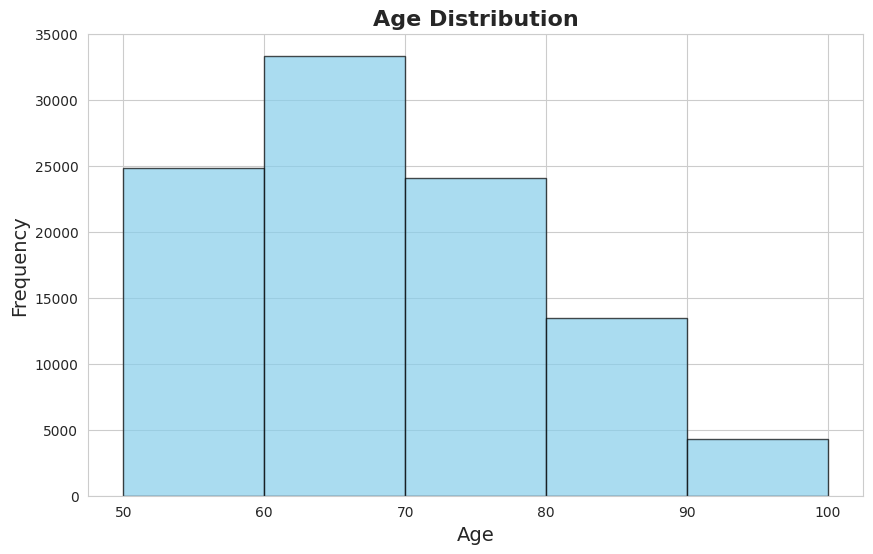

In [ ]:
# Define the age bins
age_bins = [50, 60, 70, 80, 90, df_cleaned['age'].max()+3]  # Using the maximum age as upper limit..may +3 just to make the intervals consistent kase ang max is 97
age_labels = ['50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'age_group' by applying age bins
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

# Create a histogram of ages
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['age'], bins=age_bins, edgecolor='k', alpha=0.7, color='skyblue')
plt.title('Age Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(age_bins)
plt.grid(True)

# Display the histogram
plt.show()

##### **Binned Age Group Distribution**

In [ ]:
df_age_group = df_cleaned

# Define age groups
bins = [43, 59, 78, np.inf]
labels = ['Gen X (43-58)', 'Boomers (59-77)', 'Post War (78+)']

# Use pd.cut to create a new column 'age_group'
df_age_group['age_group'] = pd.cut(df_age_group['age'], bins=bins, labels=labels, right=False)

df_age_group.head()

,cc_num,acct_num,transaction_date,transaction_num,transaction_amount,category,gender,age,birth_date,job,city,city_population,age_group
0,676000000000.0,798000000000,2020-02-10 05:53:31,a72eaa86b043eed95b25bbb25b3153a1,68.88,shopping,M,64.0,1958-12-12,Chartered loss adjuster,Dasmarinas,659019,Boomers (59-77)
1,3520000000000000.0,968000000000,2020-05-31 05:29:28,060d12f91c13871a13963041736a4702,50.06,entertainment,M,53.0,1970-08-31,"Administrator, charities/voluntary organisations",Digos,169393,Gen X (43-58)
2,4.14e+18,628000000000,2020-03-29 05:52:37,18aafb6098ab0923886c0ac83592ef8d,105.44,food_dining,M,70.0,1953-07-23,Financial controller,Calapan,133893,Boomers (59-77)
3,4870000000000000.0,863000000000,2021-02-11 17:15:04,45bbe714e51ab8a375454d39a190b0cb,38.61,food_dining,M,59.0,1964-07-18,N/A,San Fernando,121812,Boomers (59-77)
4,4720000000000000.0,257000000000,2020-09-28 08:35:59,c20ee88b451f637bc6893b7460e9fee0,82.69,gas_transport,M,68.0,1954-11-01,Dance movement psychotherapist,Laoag,111125,Boomers (59-77)


In [ ]:
df_age_group.groupby('age_group').transaction_amount.sum()

age_group
Gen X (43-58)      1388820.36
Boomers (59-77)    4241107.07
Post War (78+)     1399276.67
Name: transaction_amount, dtype: float64

In [ ]:
df_final = df_age_group.groupby('age_group').acct_num.nunique().reset_index()
display(df_final)

,age_group,acct_num
0,Gen X (43-58),19
1,Boomers (59-77),54
2,Post War (78+),19


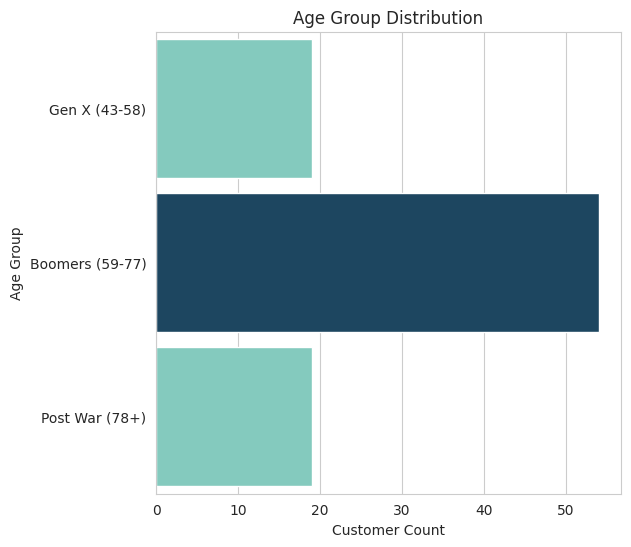

In [ ]:
palette = ['#78d6c6' if group != 'Boomers (59-77)' else '#12486b' for group in
           df_final['age_group']]

plt.figure(figsize=(6, 6))
sns.barplot(data=df_final, x='acct_num', y='age_group',
            width=0.9, palette = palette)  # 'x' and 'y' are swapped for horizontal bars
plt.ylabel('Age Group')
plt.xlabel('Customer Count')
plt.title('Age Group Distribution')

plt.show()

##### **Jobs per Account**

In [ ]:
acct_num_jobs = df.groupby('acct_num')['job'].unique()
print(acct_num_jobs)

acct_num
3843260959                [Scientific laboratory technician, nan]
20386303916                                           [Osteopath]
24058295524                          [Psychologist, occupational]
34614744133                          [nan, Exercise physiologist]
38399733986                       [Customer service manager, nan]
                                      ...                        
968000000000    [Administrator, charities/voluntary organisati...
969000000000                      [Administrator, education, nan]
971000000000                  [Research scientist (medical), nan]
989000000000                        [Database administrator, nan]
994000000000                                [Engineer, site, nan]
Name: job, Length: 89, dtype: object


##### **Number of Accounts per City**

In [ ]:
# Accounts per City
acct_num_count_per_city = df_cleaned.groupby('city')['acct_num'].nunique().reset_index(name='number of account holders')
print(acct_num_count_per_city)

                  city  number of account holders
0              Angeles                          1
1             Antipolo                          2
2              Bacolod                          1
3              Balanga                          1
4             Batangas                          1
5                Binan                          1
6               Butuan                          2
7           Cabanatuan                          1
8                Cadiz                          3
9              Calamba                          1
10             Calapan                          4
11            Caloocan                          1
12                Cebu                          1
13             Dagupan                          1
14          Dasmarinas                          4
15               Digos                          1
16             Dipolog                          1
17           Dumaguete                          2
18      General Santos                          2


##### **Number of Credit Cards per City**

In [ ]:
# Credit Cards Used per City
cc_num_count_per_city = df_cleaned.groupby('city')['cc_num'].nunique().reset_index(name='number of credit card holders').head(10)
print(cc_num_count_per_city)

         city  number of credit card holders
0     Angeles                              1
1    Antipolo                              2
2     Bacolod                              1
3     Balanga                              1
4    Batangas                              1
5       Binan                              1
6      Butuan                              2
7  Cabanatuan                              1
8       Cadiz                              3
9     Calamba                              1


##### **Associated Accounts per Credit Card**

In [ ]:
# Print the number of unique account holders (unique acct_num)
print("Count of unique account numbers:", df_cleaned['acct_num'].nunique())

# Print the number of unique credit cards (unique cc_num)
print("Count of unique credit card numbers:", df_cleaned['cc_num'].nunique())

Count of unique account numbers: 89
Count of unique credit card numbers: 69


In [ ]:
# Determine the number of unique acct_num associated with each unique cc_num

# Get a list of all unique cc_num values
unique_cc_nums = df_cleaned['cc_num'].unique()

# Create a dictionary to store cc_num as keys and the number of associated unique acct_nums as values
cc_num_to_unique_acct_count = {}

# Iterate through unique cc_num values
for cc_num in unique_cc_nums:
    unique_acct_count = len(df_cleaned[df_cleaned['cc_num'] == cc_num]['acct_num'].unique())
    cc_num_to_unique_acct_count[cc_num] = unique_acct_count

# Convert the dictionary to a DataFrame for easy analysis
result_df = pd.DataFrame(list(cc_num_to_unique_acct_count.items()), columns=['cc_num', 'unique_acct_count'])

# Print the results
display(result_df.head())

,cc_num,unique_acct_count
0,676000000000.0,1
1,3520000000000000.0,4
2,4.14e+18,1
3,4870000000000000.0,1
4,4720000000000000.0,1


In [ ]:
# Find all associated acct_num for each unique cc_num

# Get a list of all unique cc_num values
unique_cc_nums = df_cleaned['cc_num'].unique()

# Create a dictionary to store cc_num as keys and associated acct_nums as values
cc_num_to_acct_nums = {}

# Iterate through unique cc_num values
for cc_num in unique_cc_nums:
    associated_acct_nums = df_cleaned[df_cleaned['cc_num'] == cc_num]['acct_num'].unique()
    cc_num_to_acct_nums[cc_num] = associated_acct_nums

# Print the results
for cc_num, acct_nums in cc_num_to_acct_nums.items():
    print(f"cc_num: {cc_num}, Associated acct_nums: {acct_nums}")

cc_num: 676000000000.0, Associated acct_nums: ['798000000000']
cc_num: 3520000000000000.0, Associated acct_nums: ['968000000000' '587000000000' '510000000000' '531000000000']
cc_num: 4.14e+18, Associated acct_nums: ['628000000000']
cc_num: 4870000000000000.0, Associated acct_nums: ['863000000000']
cc_num: 4720000000000000.0, Associated acct_nums: ['257000000000']
cc_num: 3530000000000000.0, Associated acct_nums: ['540000000000' '201000000000' '24058295524']
cc_num: 180000000000000.0, Associated acct_nums: ['233000000000' '34614744133' '939000000000' '332000000000' '124000000000']
cc_num: 3590000000000000.0, Associated acct_nums: ['170000000000' '236000000000']
cc_num: 4010000000000.0, Associated acct_nums: ['439000000000']
cc_num: 347000000000000.0, Associated acct_nums: ['564000000000' '289000000000']
cc_num: 4050000000000000.0, Associated acct_nums: ['38399733986' '647000000000']
cc_num: 30300000000000.0, Associated acct_nums: ['838000000000' '207000000000']
cc_num: 345000000000000.0

When the same credit card number has multiple accounts associated with it, it typically means that the credit card issuer has issued separate credit card accounts or cardholders under the same primary card number. Each of these accounts operates independently but shares the same primary card number. Here's a breakdown of what this can entail:

**Primary Account Number (PAN):** The primary account number, often referred to as the PAN or card number, is the unique identifier for a credit card. It remains constant across all accounts associated with that credit card.

**Individual Account Holders:** Each account associated with the same primary card number may have its own cardholder. These individual cardholders are usually authorized users or secondary cardholders.

**Separate Statements:** Despite sharing the same primary card number, each account has its own billing statement. This means that individual cardholders are responsible for their charges and balances.

**Credit Limits:** The credit card issuer may assign separate credit limits to each account associated with the primary card number. These limits can vary based on the individual cardholder's creditworthiness and the terms of the agreement.

**Account Management:** Cardholders can manage their accounts independently, including making payments, checking balances, and reviewing transaction histories.

**Credit Reporting:** Credit card companies typically report the account activity for each individual account to credit bureaus, which means that the credit histories of individual cardholders may be impacted differently.

Reasons for having multiple accounts associated with the same primary card number can include:

**Family Members:** A primary cardholder may request additional cards for family members, such as a spouse or child, each with their own account but sharing the same credit card number.

**Business Expenses:** In a business context, a company may issue multiple cards to employees under one primary card number, allowing for easier expense tracking while maintaining separate accounts.

**Multiple Products:** A credit card issuer may offer different card products or account types under the same primary card number. For example, a single primary card number may be associated with both a credit card and a charge card.

It's important for all cardholders associated with the same primary card number to understand their responsibilities, as they are individually liable for their charges and account management. The primary cardholder, in particular, has primary responsibility for the account, including paying the bills and ensuring responsible card use by authorized users or secondary cardholders.

##### **Associated Credit Cards per Account**

In [ ]:
print("Count of unique account numbers:", df_cleaned['acct_num'].nunique())
print("Count of unique credit card numbers:", df_cleaned['cc_num'].nunique())

Count of unique account numbers: 89
Count of unique credit card numbers: 69


In [ ]:
# Find all associated cc_num values associated for each unique acct_num

# Get a list of all unique acct_num values
unique_acct_nums = df_cleaned['acct_num'].unique()

# Create a dictionary to store acct_num as keys and associated cc_nums as values
acct_num_to_cc_nums = {}

# Iterate through unique acct_num values
for acct_num in unique_acct_nums:
    associated_cc_nums = df_cleaned[df_cleaned['acct_num'] == acct_num]['cc_num'].unique()
    acct_num_to_cc_nums[acct_num] = associated_cc_nums

# Print the results
for acct_num, cc_nums in acct_num_to_cc_nums.items():
    print(f"acct_num: {acct_num}, Associated cc_nums: {cc_nums}")

acct_num: 798000000000, Associated cc_nums: ['676000000000.0']
acct_num: 968000000000, Associated cc_nums: ['3520000000000000.0']
acct_num: 628000000000, Associated cc_nums: ['4.14e+18']
acct_num: 863000000000, Associated cc_nums: ['4870000000000000.0']
acct_num: 257000000000, Associated cc_nums: ['4720000000000000.0']
acct_num: 540000000000, Associated cc_nums: ['3530000000000000.0']
acct_num: 233000000000, Associated cc_nums: ['180000000000000.0' '4.1e+18']
acct_num: 170000000000, Associated cc_nums: ['3590000000000000.0']
acct_num: 439000000000, Associated cc_nums: ['4010000000000.0']
acct_num: 564000000000, Associated cc_nums: ['347000000000000.0']
acct_num: 38399733986, Associated cc_nums: ['4050000000000000.0']
acct_num: 838000000000, Associated cc_nums: ['30300000000000.0']
acct_num: 845000000000, Associated cc_nums: ['345000000000000.0' '38900000000000.0']
acct_num: 34614744133, Associated cc_nums: ['180000000000000.0']
acct_num: 587000000000, Associated cc_nums: ['352000000000

In [ ]:
# Determine the number of unique cc_num associated with each unique acct_num

# Get a list of all unique acct_num values
unique_acct_nums = df_cleaned['acct_num'].unique()

# Create a dictionary to store acct_num as keys and the number of associated unique cc_nums as values
acct_num_to_unique_cc_count = {}

# Iterate through unique acct_num values
for acct_num in unique_acct_nums:
    unique_cc_count = len(df_cleaned[df_cleaned['acct_num'] == acct_num]['cc_num'].unique())
    acct_num_to_unique_cc_count[acct_num] = unique_cc_count

# Convert the dictionary to a DataFrame for easy analysis
result_df = pd.DataFrame(list(acct_num_to_unique_cc_count.items()), columns=['acct_num', 'unique_cc_count'])

# Display the results
display(result_df.head())

,acct_num,unique_cc_count
0,798000000000,1
1,968000000000,1
2,628000000000,1
3,863000000000,1
4,257000000000,1


When an account has multiple credit card numbers associated with it, it typically indicates that the account has been reissued one or more times with new credit card numbers while maintaining the same underlying credit card account. This practice is often referred to as "reissuing" or "replacing" a credit card. Here's what it means:

**Account Continuity:** The credit card account remains the same, with the same credit limit, account history, and account number, despite changes in the credit card number.

**Card Replacement:** Credit card numbers may be replaced for various reasons, such as when a card is lost, stolen, or compromised due to a data breach. In these cases, the credit card issuer issues a new card with a different card number to enhance security.

**Expiration:** Credit cards have expiration dates. When a card expires, the issuer typically sends a replacement card with a new card number and an updated expiration date, but the account itself remains unchanged.

**Enhanced Security:** Changing the credit card number periodically enhances security by reducing the risk associated with a compromised or leaked card number.

**No Impact on Account:** The replacement of a credit card number does not affect the credit history, credit score, or terms and conditions of the underlying credit card account. It's essentially an administrative change to the card number.

**Account Management: **Cardholders can continue to manage their account as usual, even with the new card number. They should update any automatic payments or recurring billing arrangements with the new card information.

**Usage Continuity: **Any pending transactions, authorized charges, or recurring payments linked to the old card number are typically automatically transferred to the new card number to ensure uninterrupted service.

**Activation:** Cardholders are usually required to activate the new card upon receiving it. This process may involve confirming their identity and acknowledging receipt of the replacement card.

In summary, having multiple credit card numbers associated with the same account is a common practice used by credit card issuers to enhance security and replace cards that may be compromised or expire. It does not affect the core terms and conditions of the account, and cardholders can continue to use and manage their accounts as usual with the new card number.

It is also possible for account holders to have multiple credit card numbers associated with the same account due to different credit card offerings or tiers. Here's how this scenario typically works:

**Multiple Card Offerings:** Credit card issuers often provide a range of credit card offerings with varying features, benefits, and rewards programs. These offerings may include cards affiliated with different payment networks like Visa, MasterCard, American Express, or Discover.

**Tiers or Levels:** Some credit card issuers have tiered credit card programs where cardholders can choose from different levels of cards, such as bronze, silver, or gold. Each tier may come with different annual fees, credit limits, rewards, and benefits.

**Multiple Card Numbers: **When an account holder applies for or upgrades to a different card offering or tier, they may receive a new credit card with a different card number. The underlying credit card account remains the same, but the card's features and terms may change.

**Usage and Benefits:** The account holder can use the new card just like the previous one but with any additional benefits or features associated with the new card offering or tier. For example, a gold-tier card might offer higher cashback rewards or travel perks compared to a bronze-tier card from the same issuer.

**Account Continuity:** Despite the change in card numbers and card features, the account history, credit limit, and other core aspects of the credit card account remain consistent.

**Management: **The cardholder can manage multiple cards associated with the same account through a single account portal, making it convenient to track spending, make payments, and access account information.

This practice allows credit card issuers to cater to a wide range of customer preferences and financial needs. Account holders can select the card that best aligns with their spending habits and goals, whether it's a particular payment network, a tier with specific rewards, or other features that suit their lifestyle.

##### **Outlier Detection & Removal on city_population**

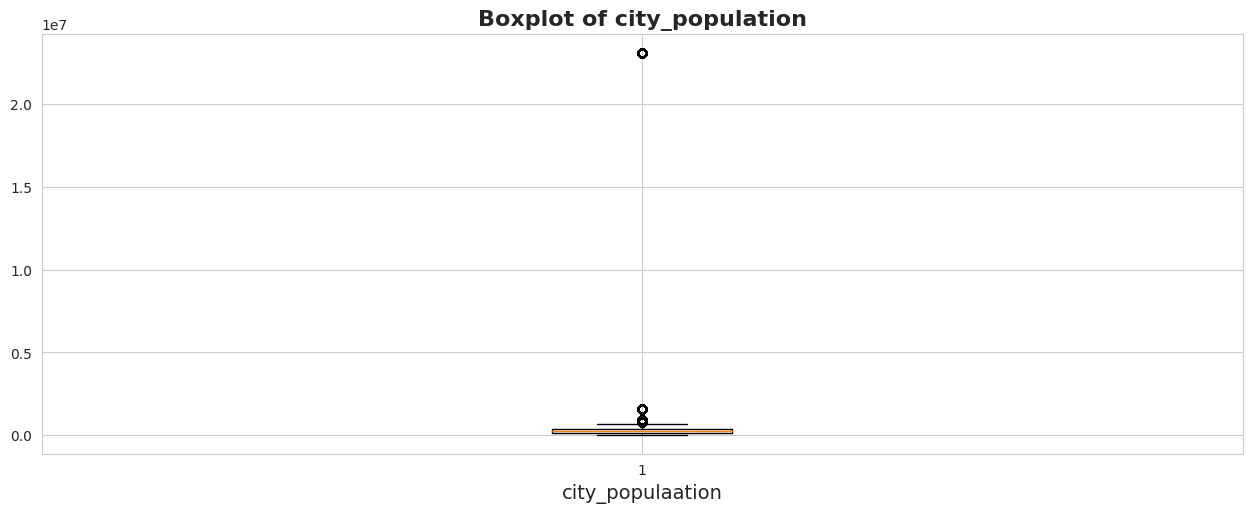

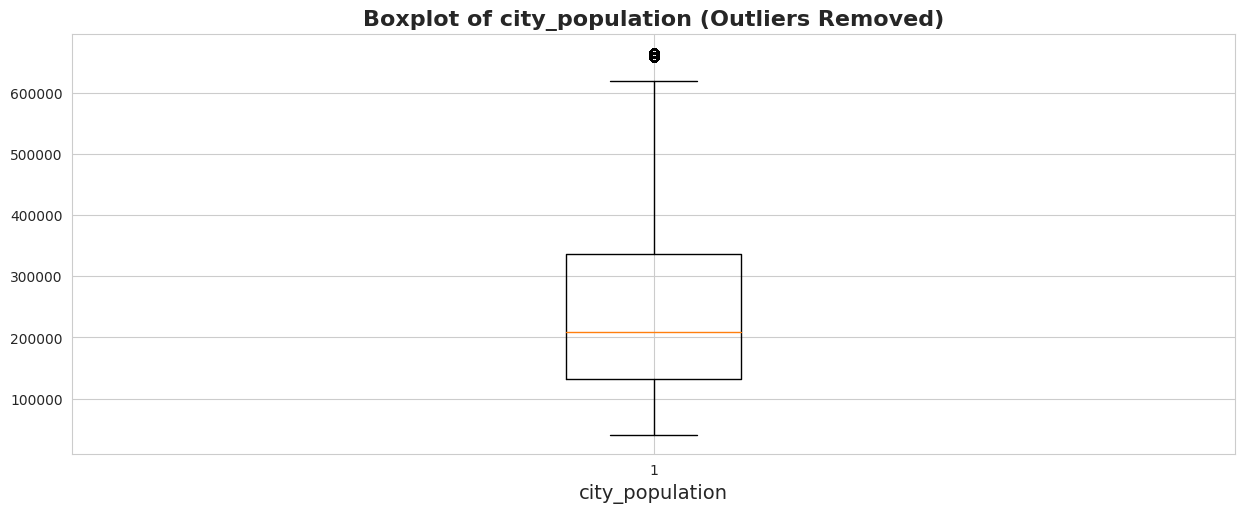

In [ ]:
# Detect outliers in 'city_population' by visualizing using a boxplot
plt.figure(figsize=(15.5, 12))
plt.subplot(2,1,1)
plt.boxplot(df_cleaned['city_population'])
plt.title('Boxplot of city_population', fontsize=16, fontweight='bold')
plt.xlabel('city_populaation', fontsize=14)
plt.show()

# Calculate quartiles and IQR of 'city_population'
Q1 = df_cleaned['city_population'].quantile(0.25)
Q3 = df_cleaned['city_population'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of 'city_pop' for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in 'city_population' and create a new DataFrame
condition = (df_cleaned['city_population'] >= lower_bound) & (df_cleaned['city_population'] <= upper_bound)
df_cleaned_no_outliers_in_city_population = df_cleaned[condition]

# Visualize using a boxplot
plt.figure(figsize=(15, 12))
plt.subplot(2,1,2)
plt.boxplot(df_cleaned_no_outliers_in_city_population['city_population'])
plt.title('Boxplot of city_population (Outliers Removed)', fontsize=16, fontweight='bold')
plt.xlabel('city_population', fontsize=14)
plt.show()

### **Number of Transactions**

##### **Binned Age Group Comparison based on Number of Transactions**

In [ ]:
# Group by age group and count the 'transaction_num'
transaction_count_and_amt_spent_per_age_group = df_age_group.groupby('age_group').agg({'transaction_amount': 'sum', 'transaction_num': 'nunique'})

age_group_agg = transaction_count_and_amt_spent_per_age_group.reset_index()

display(age_group_agg)

,age_group,transaction_amount,transaction_num
0,Gen X (43-58),1388820.36,19877
1,Boomers (59-77),4241107.07,60288
2,Post War (78+),1399276.67,19835


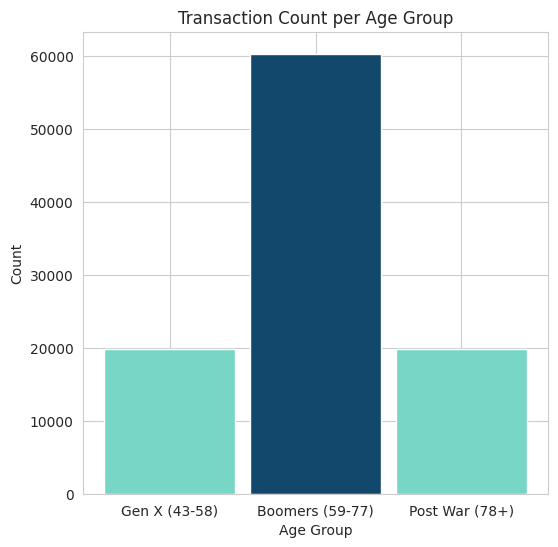

In [ ]:
# Bar graph showing transaction count per age group

# Create the bar graph
plt.figure(figsize=(6, 6))
plt.bar(age_group_agg['age_group'], age_group_agg['transaction_num'], color=['#78d6c6', '#12486b', '#78d6c6'], width = 0.9)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Transaction Count per Age Group')

plt.show()

In [ ]:
# Define age groups
bins = [43, 59, 78, np.inf]
labels = ['Gen X (43-58)', 'Boomers (59-77)', 'Post War (78+)']

# Use pd.cut to create a new column 'age_group'
df_age_group['age_group'] = pd.cut(df_age_group['age'], bins=bins, labels=labels, right=False)

df_age_group.head()

,cc_num,acct_num,transaction_date,transaction_num,transaction_amount,category,gender,age,birth_date,job,city,city_population,age_group
0,676000000000.0,798000000000,2020-02-10 05:53:31,a72eaa86b043eed95b25bbb25b3153a1,68.88,shopping,M,64.0,1958-12-12,Chartered loss adjuster,Dasmarinas,659019,Boomers (59-77)
1,3520000000000000.0,968000000000,2020-05-31 05:29:28,060d12f91c13871a13963041736a4702,50.06,entertainment,M,53.0,1970-08-31,"Administrator, charities/voluntary organisations",Digos,169393,Gen X (43-58)
2,4.14e+18,628000000000,2020-03-29 05:52:37,18aafb6098ab0923886c0ac83592ef8d,105.44,food_dining,M,70.0,1953-07-23,Financial controller,Calapan,133893,Boomers (59-77)
3,4870000000000000.0,863000000000,2021-02-11 17:15:04,45bbe714e51ab8a375454d39a190b0cb,38.61,food_dining,M,59.0,1964-07-18,N/A,San Fernando,121812,Boomers (59-77)
4,4720000000000000.0,257000000000,2020-09-28 08:35:59,c20ee88b451f637bc6893b7460e9fee0,82.69,gas_transport,M,68.0,1954-11-01,Dance movement psychotherapist,Laoag,111125,Boomers (59-77)


In [ ]:
# Group by age group and get the average spend, number of account numbers, number of transactions
avg_transaction_count_and_avg_spend_per_age_group = df_age_group.groupby('age_group').agg({'transaction_amount': 'mean', 'acct_num': 'nunique', 'transaction_num': 'nunique'})

age_group_ave_agg = avg_transaction_count_and_avg_spend_per_age_group.reset_index()

display(age_group_ave_agg)

,age_group,transaction_amount,acct_num,transaction_num
0,Gen X (43-58),69.870723,19,19877
1,Boomers (59-77),70.347450,54,60288
2,Post War (78+),70.545837,19,19835


In [ ]:
#Get the average frequency ofeach age group
age_group_ave_agg['avg_frequency'] = age_group_ave_agg['transaction_num'] / age_group_ave_agg['acct_num']

age_group_ave_agg.head()

,age_group,transaction_amount,acct_num,transaction_num,avg_frequency
0,Gen X (43-58),69.870723,19,19877,1046.157895
1,Boomers (59-77),70.347450,54,60288,1116.444444
2,Post War (78+),70.545837,19,19835,1043.947368


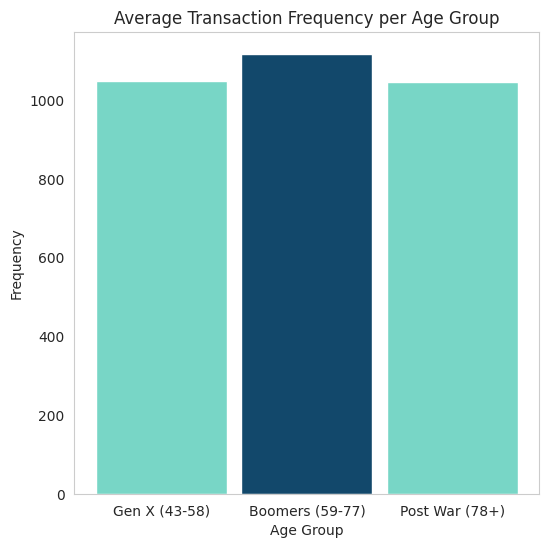

In [ ]:
# Bar graph showing average transaction count per age group

# Create the bar graph
plt.figure(figsize=(6, 6))
plt.bar(age_group_ave_agg['age_group'], age_group_ave_agg['avg_frequency'], color=['#78d6c6', '#12486B', '#78d6c6'], width = 0.9)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Average Transaction Frequency per Age Group')

plt.grid(False)

plt.show()

##### **Number of Transactions per Credit Card**

In [ ]:
# Transaction Count per Credit Card
trans_num_count_per_cc_num = df_cleaned.groupby('cc_num')['transaction_num'].count().reset_index(name='number of transactions')

# This will give you a DataFrame with two columns: 'city' and 'number of transactions'
print(trans_num_count_per_cc_num.sort_values(by='number of transactions',ascending=False))

                cc_num  number of transactions
0    180000000000000.0                    6373
14  3520000000000000.0                    5652
9     30300000000000.0                    3538
63      639000000000.0                    2833
66  6550000000000000.0                    2833
..                 ...                     ...
21  3600000000000000.0                       9
4   2300000000000000.0                       8
64  6530000000000000.0                       8
52     4860000000000.0                       7
47  4670000000000000.0                       7

[69 rows x 2 columns]


##### **Number of Transactions per Account**

In [ ]:
# Transaction Count per Account
trans_num_count_per_acct_num = df_cleaned.groupby('acct_num')['transaction_num'].count().reset_index(name='number of transactions')

# This will give you a DataFrame with two columns: 'city' and 'number of transactions'
print(trans_num_count_per_acct_num.sort_values(by='number of transactions',ascending=False))

        acct_num  number of transactions
75  902000000000                    4231
69  845000000000                    3531
13  233000000000                    2834
47  581000000000                    2157
34  439000000000                    2125
..           ...                     ...
36  470000000000                       8
9   224000000000                       7
1   138000000000                       7
11  229000000000                       7
51  644000000000                       7

[89 rows x 2 columns]


##### **Gender Comparison based on Number of Transactions**

In [ ]:
df_cleaned['transaction_num'].count()

100000

In [ ]:
df_cleaned[df_cleaned['gender']=='F'].transaction_num.count()

5704

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].transaction_num.count()

94296

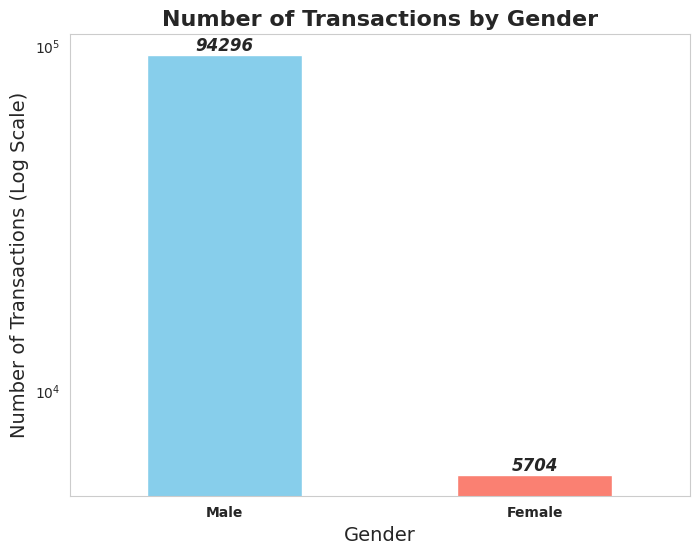

In [ ]:
# Group the data by 'gender' and calculate the Number of Transactions per gender
gender_total_count = df_cleaned.groupby('gender')['transaction_num'].count()

# Sort the data in descending order of transaction count
gender_total_count = gender_total_count.sort_values(ascending=False)

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = gender_total_count.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Transactions (Log Scale)', fontsize=14)
plt.title('Number of Transactions by Gender', fontsize=16, fontweight='bold')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add count labels inside the bars (rounded and in bold)
for i, v in enumerate(gender_total_count):
    plt.text(i, v, f'{int(v)}', ha='center', va='bottom', fontsize=12, fontweight='bold', fontstyle='italic')

# Remove grid lines
plt.grid(False)

# Replace gender labels with 'Male' and 'Female' (in bold)
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'], rotation=0, fontweight='bold')

# Show the bar graph
plt.show()

##### **Top 5 Accounts based on Number of Transactions**

In [ ]:
# Top 5 Accounts by Number of Transactions (gender-neutral)
acct_num_by_transaction_count = df_cleaned.groupby('acct_num')['transaction_num'].count()
display(acct_num_by_transaction_count.sort_values(ascending=False).nlargest(5))

acct_num
902000000000    4231
845000000000    3531
233000000000    2834
581000000000    2157
439000000000    2125
Name: transaction_num, dtype: int64

###### **Top 5 Acounts for Males based on Number of Transactions**

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].groupby('acct_num').transaction_num.count().sort_values(ascending=False)

acct_num
902000000000    4231
845000000000    3531
233000000000    2834
581000000000    2126
439000000000    2125
                ... 
647000000000       8
644000000000       7
224000000000       7
138000000000       7
229000000000       7
Name: transaction_num, Length: 84, dtype: int64

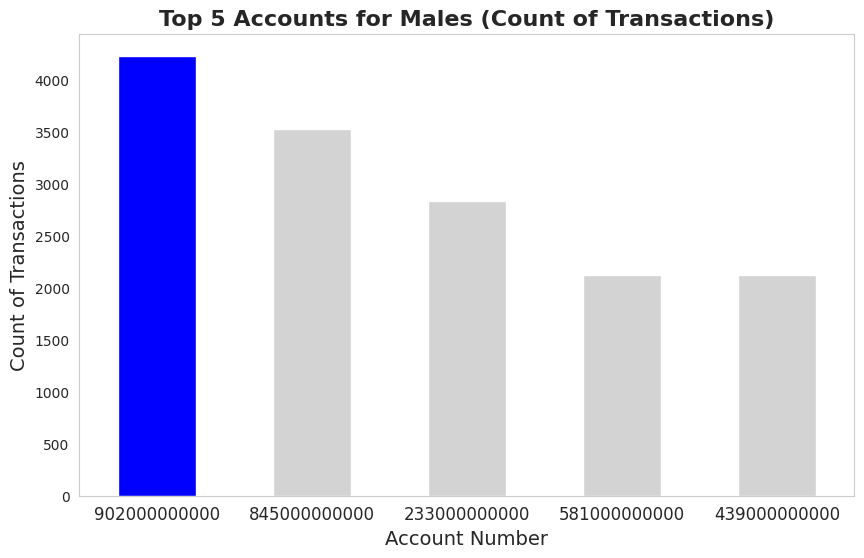

In [ ]:
# Filter the DataFrame for male transactions
male_transactions = df_cleaned[df_cleaned['gender'] == 'M']

# Group the data by 'acct_num' and calculate the count of transactions for each acct_num
acct_num_counts = male_transactions['acct_num'].value_counts()

# Select the top 5 acct_num
top_5_acct_num = acct_num_counts.head(5)

# Create a bar graph with only the top 1 category in color and the rest greyed out
plt.figure(figsize=(10, 6))
colors = ['blue' if category == top_5_acct_num.index[0] else 'lightgrey' for category in top_5_acct_num.index]
bars = top_5_acct_num.plot(kind='bar', color=colors)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Count of Transactions', fontsize=14)
plt.title('Top 5 Accounts for Males (Count of Transactions)', fontsize=16, fontweight='bold')

# Remove grid lines

plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

###### **Top 5 Accounts for Females based on Number of Transactions**

In [ ]:
df_cleaned[df_cleaned['gender']=='F'].groupby('acct_num').transaction_num.count().sort_values(ascending=False)

acct_num
404000000000    2121
994000000000    1421
946000000000     714
668000000000     712
878000000000     705
581000000000      31
Name: transaction_num, dtype: int64

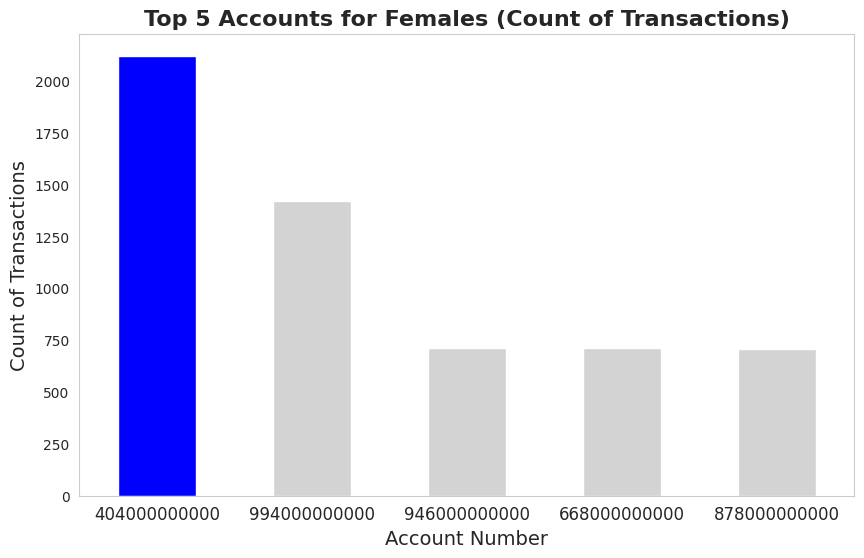

In [ ]:
# Filter the DataFrame for Female transactions
female_transactions = df_cleaned[df_cleaned['gender'] == 'F']

# Group the data by 'category' and calculate the count of transactions for each category
acct_num_counts = female_transactions['acct_num'].value_counts()

# Select the top 5 categories
top_5_acct_num = acct_num_counts.head(5)

# Create a bar graph with only the top 1 category in color and the rest greyed out
plt.figure(figsize=(10, 6))
colors = ['blue' if category == top_5_acct_num.index[0] else 'lightgrey' for category in top_5_acct_num.index]
bars = top_5_acct_num.plot(kind='bar', color=colors)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Count of Transactions', fontsize=14)
plt.title('Top 5 Accounts for Females (Count of Transactions)', fontsize=16, fontweight='bold')

# Remove grid lines

plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

##### **Top 5 Categories based on Number of Transactions**

In [ ]:
# Top 5 Categories by Number of Transactions (gender-neutral)
categories_by_transaction_count = df_cleaned.groupby('category')['transaction_num'].count()
display(categories_by_transaction_count.sort_values(ascending=False).nlargest(5))

category
shopping         14049
grocery          10921
gas_transport     9366
misc              9180
kids_pets         9171
Name: transaction_num, dtype: int64

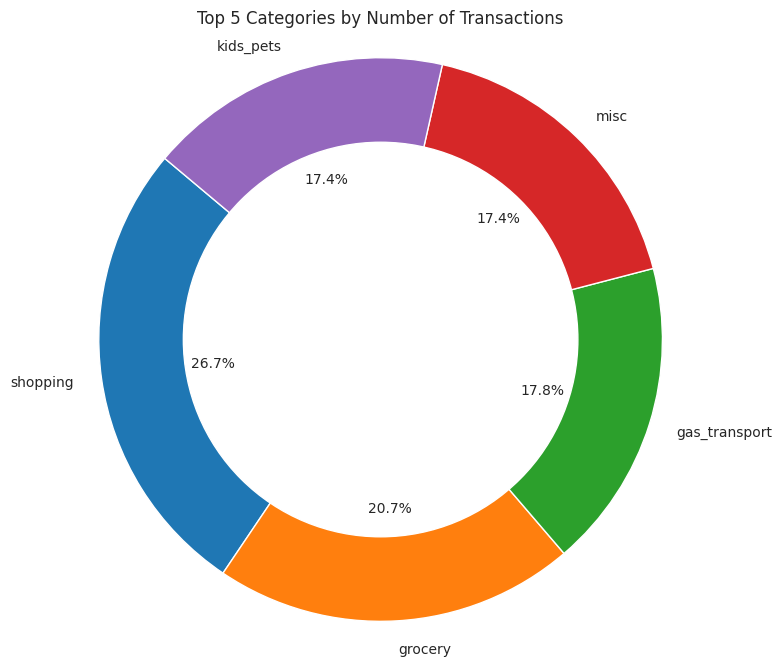

In [ ]:
# Create a donut chart
plt.figure(figsize=(8, 8))
plt.pie(categories_by_transaction_count.nlargest(5), labels=categories_by_transaction_count.nlargest(5).index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4, edgecolor='w'))

# Draw a circle in the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Top 5 Categories by Number of Transactions')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.show()

###### **Top 5 Categories for Males**

In [ ]:
df_cleaned['category'].unique()

array(['shopping', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'N/A', 'personal_care', 'grocery', 'travel',
       'misc', 'health_fitness'], dtype=object)

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].groupby('category').transaction_num.count().sort_values(ascending=False)

category
shopping          13229
grocery           10278
gas_transport      8857
misc               8662
kids_pets          8644
home               8562
N/A                7195
personal_care      7032
food_dining        6869
entertainment      6723
health_fitness     4733
travel             3512
Name: transaction_num, dtype: int64

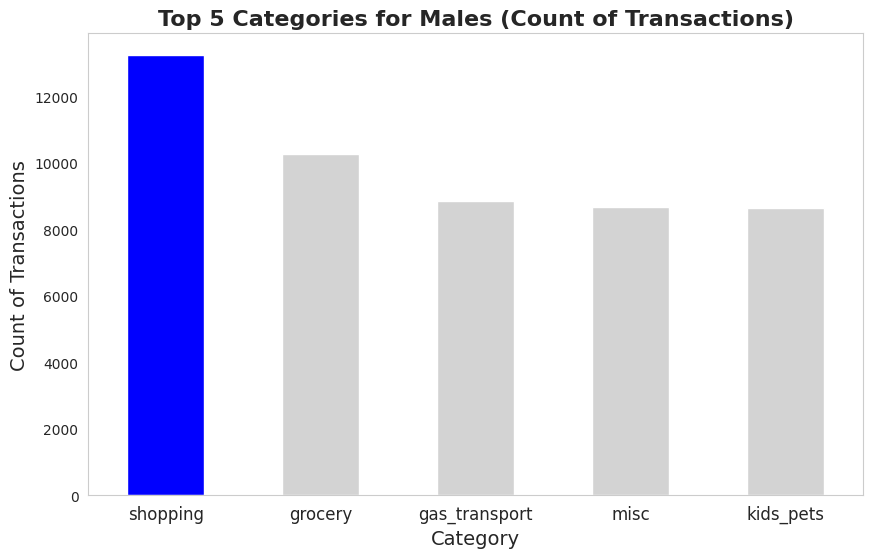

In [ ]:
# Filter the DataFrame for male transactions
male_transactions = df_cleaned[df_cleaned['gender'] == 'M']

# Group the data by 'category' and calculate the count of transactions for each category
category_counts = male_transactions['category'].value_counts()

# Select the top 5 categories
top_5_categories = category_counts.head(5)

# Create a bar graph with only the top 1 category in color and the rest greyed out
plt.figure(figsize=(10, 6))
colors = ['blue' if category == top_5_categories.index[0] else 'lightgrey' for category in top_5_categories.index]
bars = top_5_categories.plot(kind='bar', color=colors)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count of Transactions', fontsize=14)
plt.title('Top 5 Categories for Males (Count of Transactions)', fontsize=16, fontweight='bold')

# Remove grid lines

plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

In [ ]:
df_cleaned['transaction_num'].count()

100000

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].transaction_num.count() + df_cleaned[df_cleaned['gender']=='F'].transaction_num.count()

100000

###### **Top 5 Categories for Females**

In [ ]:
df_cleaned['category'].unique()

array(['shopping', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'N/A', 'personal_care', 'grocery', 'travel',
       'misc', 'health_fitness'], dtype=object)

In [ ]:
df_cleaned[df_cleaned['gender']=='F'].groupby('category').transaction_num.count().sort_values(ascending=False)

category
shopping          820
grocery           643
kids_pets         527
misc              518
gas_transport     509
home              508
food_dining       443
N/A               413
personal_care     405
entertainment     397
health_fitness    308
travel            213
Name: transaction_num, dtype: int64

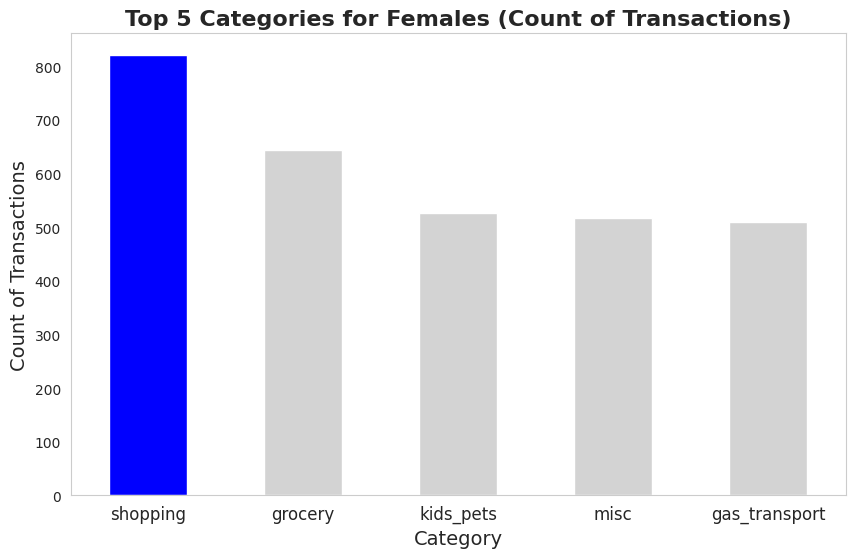

In [ ]:
# Filter the DataFrame for male transactions
female_transactions = df_cleaned[df_cleaned['gender'] == 'F']

# Group the data by 'category' and calculate the count of transactions for each category
category_counts = female_transactions['category'].value_counts()

# Select the top 5 categories
top_5_categories = category_counts.head(5)

# Create a bar graph with only the top 1 category in color and the rest greyed out
plt.figure(figsize=(10, 6))
colors = ['blue' if category == top_5_categories.index[0] else 'lightgrey' for category in top_5_categories.index]
bars = top_5_categories.plot(kind='bar', color=colors)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count of Transactions', fontsize=14)
plt.title('Top 5 Categories for Females (Count of Transactions)', fontsize=16, fontweight='bold')

# Remove grid lines

plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

In [ ]:
df_cleaned['transaction_num'].count()

100000

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].transaction_num.count() + df_cleaned[df_cleaned['gender']=='F'].transaction_num.count()

100000

##### **Top 5 Categories per Age Bin based on Number of Transactions**

In [ ]:
df_cleaned['category'].unique()

array(['shopping', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'N/A', 'personal_care', 'grocery', 'travel',
       'misc', 'health_fitness'], dtype=object)

In [ ]:
# Define the age bins
age_bins = [50, 60, 70, 80, 90, df_cleaned['age'].max() + 3]  # Using the maximum age as upper limit..may +3 just to make the intervals consistent kase ang max is 97
age_labels = ['50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'age_group' by applying age bins
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

# Group by 'age_group' and 'category', and calculate the number of transactions
grouped = df_cleaned.groupby(['age_group', 'category']).size().reset_index(name='number of transactions')

# Sort the categories in descending order of the number of transactions within each age group
sorted_df = grouped.sort_values(by=['age_group', 'number of transactions'], ascending=[True, False])

# Use groupby and head to select the top 5 categories for each age group
top_5_categories_per_age = (
    sorted_df.groupby('age_group').head(5).reset_index(drop=True)
)

# Print the DataFrame
print(top_5_categories_per_age)

   age_group       category  number of transactions
0      50-59       shopping                    3747
1      50-59        grocery                    2880
2      50-59  gas_transport                    2498
3      50-59           home                    2440
4      50-59           misc                    2398
5      60-69       shopping                    4770
6      60-69        grocery                    3673
7      60-69           misc                    3166
8      60-69      kids_pets                    3165
9      60-69  gas_transport                    3115
10     70-79       shopping                    3744
11     70-79        grocery                    2988
12     70-79      kids_pets                    2539
13     70-79  gas_transport                    2508
14     70-79           misc                    2483
15     80-89       shopping                    1188
16     80-89        grocery                     939
17     80-89  gas_transport                     829
18     80-89

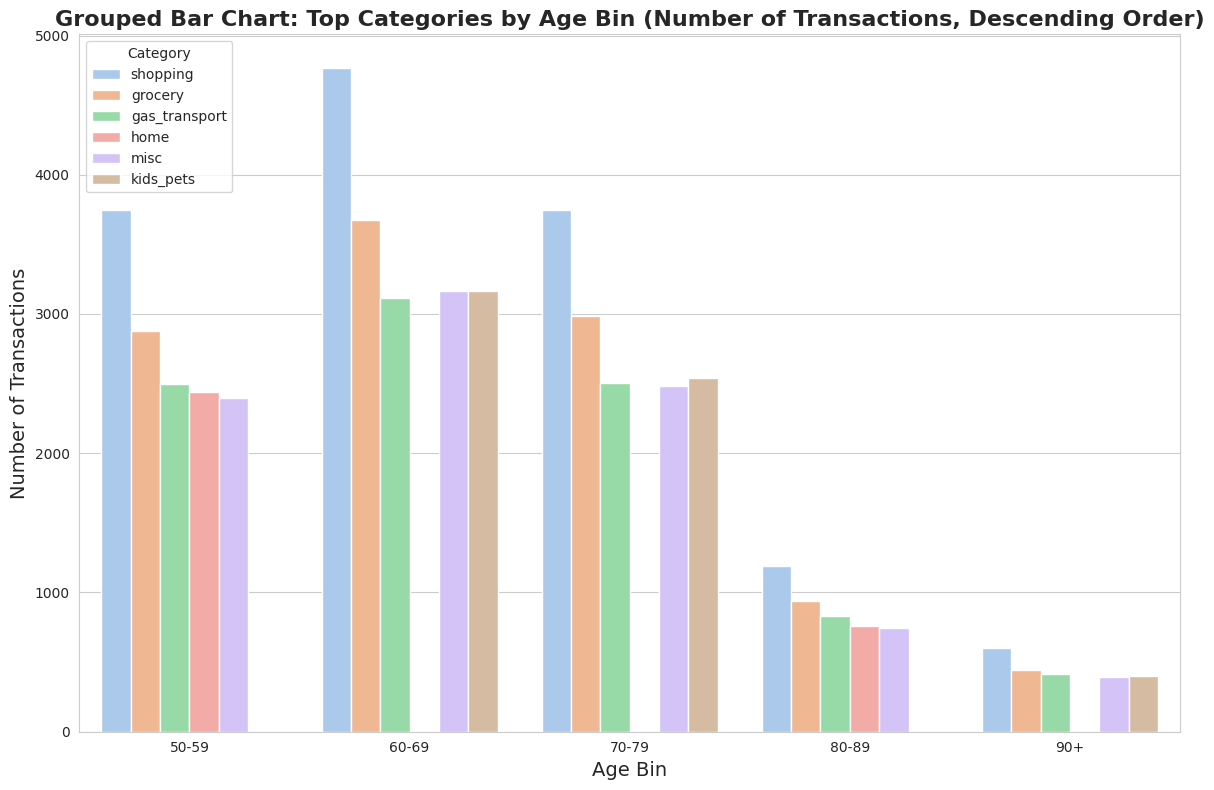

In [ ]:
# Define the age bins
age_bins = [50, 60, 70, 80, 90, df_cleaned['age'].max() + 1]  # Using the maximum age as upper limit..may +3 just to make the intervals consistent kase ang max is 97
age_labels = ['50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'age_group' by applying age bins
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

# Group by 'age_group' and 'category', and calculate the count of transactions
grouped = df_cleaned.groupby(['age_group', 'category']).size().reset_index(name='number of transactions')

# Sort the categories in descending order of the number of transactions within each age group
sorted_df = grouped.sort_values(by=['age_group', 'number of transactions'], ascending=[True, False])

# Use groupby and head to select the top 5 categories for each age group
top_5_categories_per_age = (
    sorted_df.groupby('age_group').head(5).reset_index(drop=True)
)

# Define a custom pastel color palette
pastel_colors = sns.color_palette("pastel", n_colors=len(top_5_categories_per_age['category'].unique()))

# Create a grouped bar chart using Seaborn with pastel colors
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the top categories for each age group with pastel colors
ax = sns.barplot(x='age_group', y='number of transactions', hue='category', data=top_5_categories_per_age, palette=pastel_colors, errorbar=None)

# Customize the plot
plt.title('Grouped Bar Chart: Top Categories by Age Bin (Number of Transactions, Descending Order)', fontsize=16, fontweight='bold')
plt.xlabel('Age Bin', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

### **Amount Spent**

##### **Time Series Analysis (per Month)**

Dataset has a period ranging from 2020-2021

In [ ]:
# Extract unique years from 'transaction_date'
unique_years = df_cleaned['transaction_date'].dt.year.unique()

# Print the unique years
print("Unique years in transaction_date:", unique_years)

Unique years in transaction_date: [2020 2021]


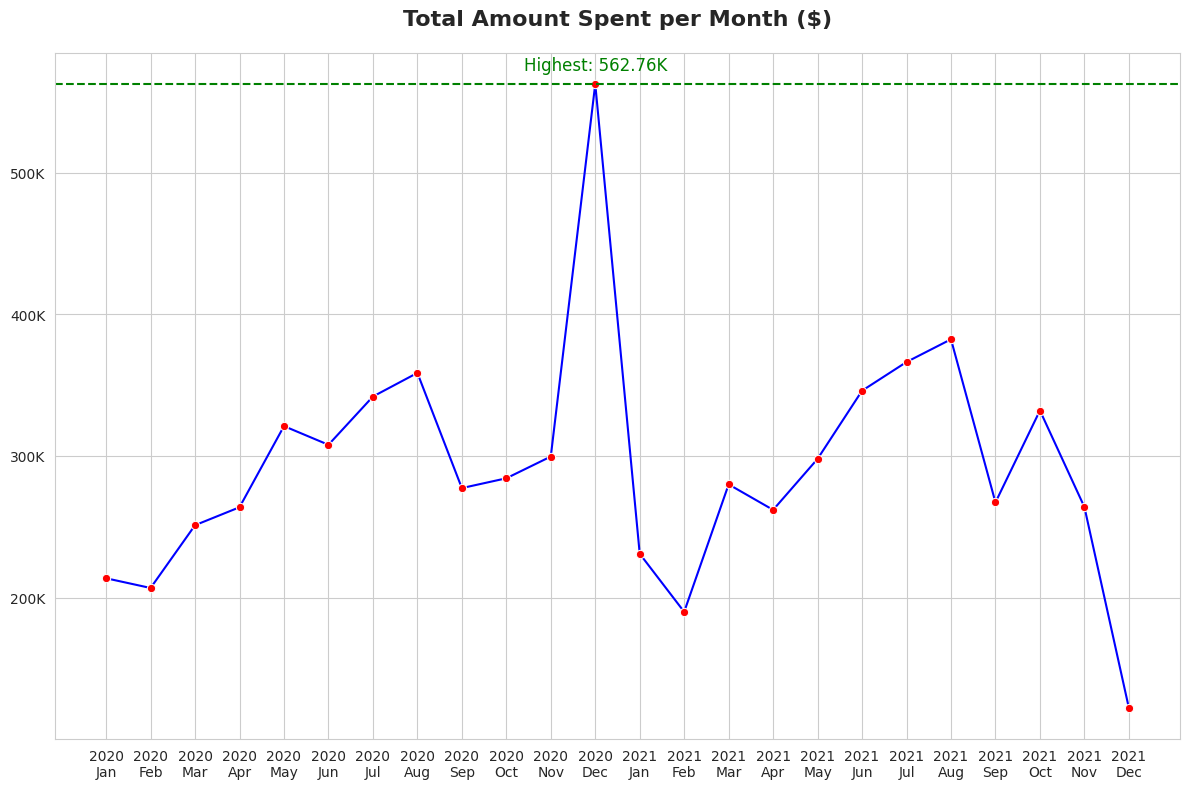

In [ ]:
# Extract year and month from the 'date' column
df_cleaned['year'] = df_cleaned['transaction_date'].dt.year
df_cleaned['month'] = df_cleaned['transaction_date'].dt.month

# Group by year and month and calculate the total amount spent per month
monthly_total_amount = df_cleaned.groupby(['year', 'month'])['transaction_amount'].sum().reset_index()

# Create a custom date column with numerical format (YYYYMM)
monthly_total_amount['date_numeric'] = monthly_total_amount['year'] * 100 + monthly_total_amount['month']

# Sort the DataFrame by 'date_numeric' in ascending order
monthly_total_amount = monthly_total_amount.sort_values(by='date_numeric')

# Convert the numerical date to custom format (YYYY\nMMM)
monthly_total_amount['date_str'] = monthly_total_amount['date_numeric'].apply(
    lambda x: f"{int(x/100)}\n{datetime.strptime(str(x % 100), '%m').strftime('%b')}")

# Convert total amount to thousands (k) and format with commas
monthly_total_amount['transaction_amount'] = monthly_total_amount['transaction_amount'] / 1000

# Create a line plot using Seaborn for the Time Series Analysis
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the total amount spent per month with a red marker
ax = sns.lineplot(x='date_str', y='transaction_amount', data=monthly_total_amount, marker='o', color='b', markerfacecolor='red')

# Find the highest point (max_amount) and its corresponding date_str
max_amount = monthly_total_amount['transaction_amount'].max()
max_date_str = monthly_total_amount[monthly_total_amount['transaction_amount'] == max_amount]['date_str'].values[0]

# Format the highest amount with commas for thousands
max_amount_formatted = f'{max_amount:,.2f}K'

# Calculate the position for the highest amount label
x_position = monthly_total_amount[monthly_total_amount['date_str'] == max_date_str].index[0]
y_position = max_amount

# Trace the highest amount on the y-axis with a horizontal line
ax.axhline(y=y_position, color='green', linestyle='--')

# Indicate the highest amount on the y-axis with a label above the dashed line
ax.text(x_position, y_position + 10, f'Highest: {max_amount_formatted}', color='green', fontsize=12, ha='center')

# Hide the x-axis and y-axis labels
ax.set_xlabel('')
ax.set_ylabel('')

# Add comma formatting to y-axis labels
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}K'))  # Include 'K' in the y-axis labels

# Set the title with additional space from the graph area
plt.title('Total Amount Spent per Month ($)', pad=20, fontsize=16, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

##### **Gender Comparison based on Total Amount Spent**

In [ ]:
df_cleaned['transaction_amount'].sum()

7029204.099999999

In [ ]:
df_cleaned[df_cleaned['gender']=='F'].transaction_amount.sum()

379000.39

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].transaction_amount.sum()

6650203.710000001

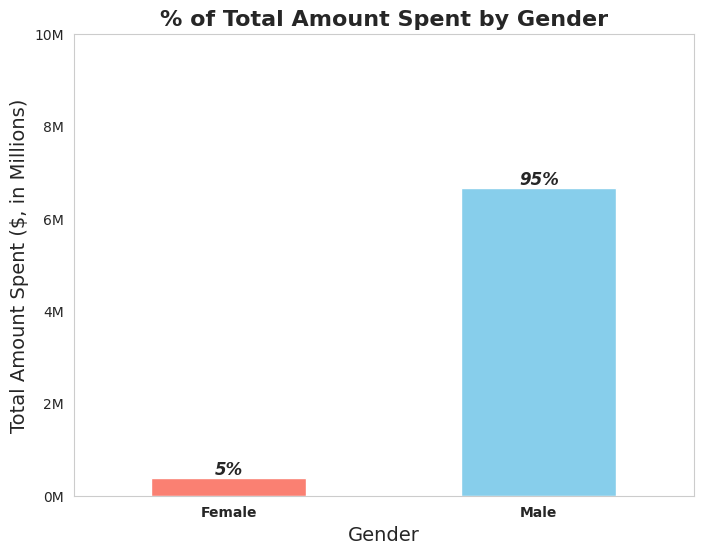

In [ ]:
# Group the data by 'gender' and calculate the total amount spent per gender
gender_total_amount = df_cleaned.groupby('gender')['transaction_amount'].sum()

# Convert total amount to millions and format with commas
gender_total_amount_millions = gender_total_amount / 1_000_000  # Divide by 1 million
gender_total_amount_millions = gender_total_amount_millions.round(2)  # Round to 2 decimal places

# Calculate the percentage distribution
total_amount_all = gender_total_amount_millions.sum()
percentage_distribution = (gender_total_amount_millions / total_amount_all) * 100

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = gender_total_amount_millions.plot(kind='bar', color=['salmon', 'skyblue'])
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Total Amount Spent ($, in Millions)', fontsize=14)
plt.title('% of Total Amount Spent by Gender', fontsize=16, fontweight='bold')

# Set y-axis limits to stretch until 10M
plt.ylim(0, 10)

# Format y-axis labels to include millions and remove decimals
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%dM'))

# Add percentage labels inside the bars (rounded and in bold)
for i, v in enumerate(gender_total_amount_millions):
    plt.text(i, v, f'{int(percentage_distribution[i] + 0.5)}%', ha='center', va='bottom', fontsize=12, fontweight='bold', fontstyle='italic')

# Remove grid lines
plt.grid(False)

# Replace gender labels with 'Female' and 'Male' (in bold)
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'], rotation=0, fontweight='bold')

# Show the bar graph
plt.show()

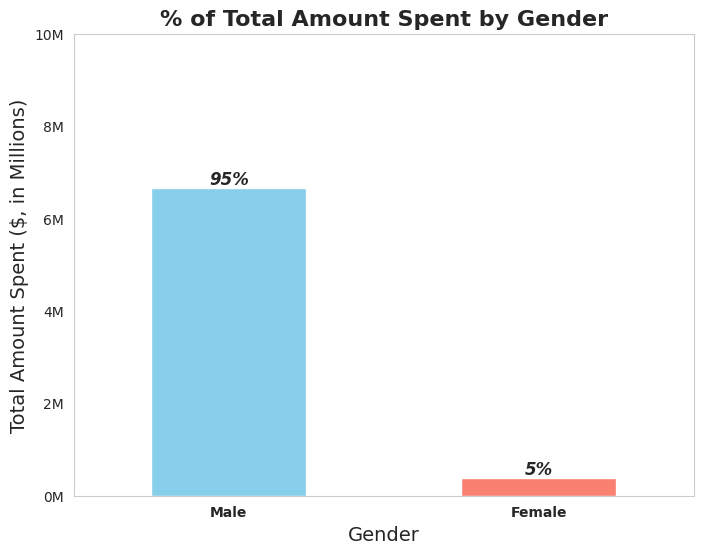

In [ ]:
# Group the data by 'gender' and calculate the total amount spent per gender
gender_total_amount = df_cleaned.groupby('gender')['transaction_amount'].sum()

# Convert total amount to millions and format with commas
gender_total_amount_millions = gender_total_amount / 1_000_000  # Divide by 1 million
gender_total_amount_millions = gender_total_amount_millions.round(2)  # Round to 2 decimal places

# Calculate the percentage distribution
total_amount_all = gender_total_amount_millions.sum()
percentage_distribution = (gender_total_amount_millions / total_amount_all) * 100

# Sort the data in descending order of percentage
gender_total_amount_millions = gender_total_amount_millions.sort_values(ascending=False)
percentage_distribution = percentage_distribution.sort_values(ascending=False)

# Create a bar graph
plt.figure(figsize=(8, 6))
bars = gender_total_amount_millions.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Total Amount Spent ($, in Millions)', fontsize=14)
plt.title('% of Total Amount Spent by Gender', fontsize=16, fontweight='bold')

# Set y-axis limits to stretch until 10M
plt.ylim(0, 10)

# Format y-axis labels to include millions and remove decimals
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%dM'))

# Add percentage labels inside the bars (rounded and in bold)
for i, v in enumerate(gender_total_amount_millions):
    plt.text(i, v, f'{int(percentage_distribution.iloc[i] + 0.5)}%', ha='center', va='bottom', fontsize=12, fontweight='bold', fontstyle='italic')

# Remove grid lines
plt.grid(False)

# Replace gender labels with 'Female' and 'Male' (in bold)
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'], rotation=0, fontweight='bold')

# Show the bar graph
plt.show()

##### **Binned Age Comparison based on Total Amount Spent**

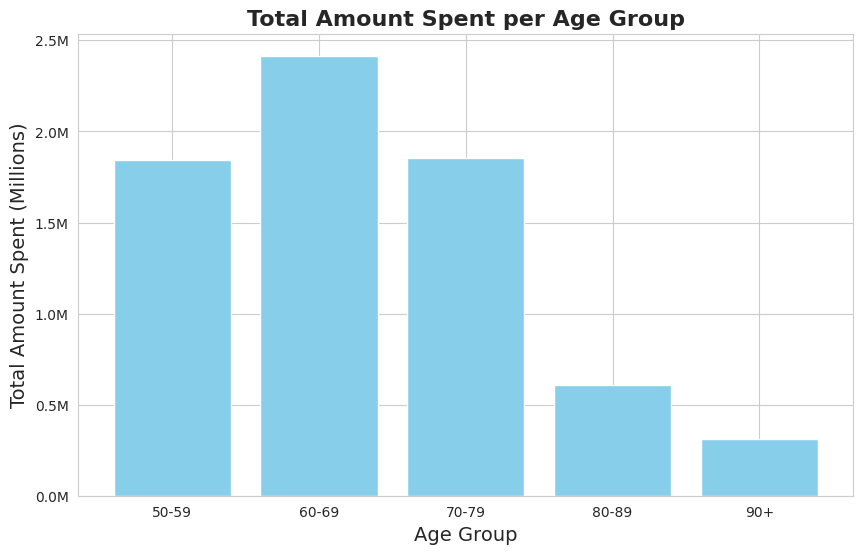

In [ ]:
# Define the age bins
age_bins = [50, 60, 70, 80, 90, df_cleaned['age'].max()+3]  # Using the maximum age as upper limit..may +3 just to make the intervals consistent kase ang max is 97
age_labels = ['50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'age_group' by applying age bins
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

# Group data by 'age_group' and calculate the sum of 'transaction_amount' for each group
amt_per_age_group = df_cleaned.groupby('age_group')['transaction_amount'].sum().reset_index()

# Create a function to format the y-axis labels in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

# Create a bar chart to visualize the data with y-axis labels formatted in millions
plt.figure(figsize=(10, 6))
plt.bar(amt_per_age_group['age_group'], amt_per_age_group['transaction_amount'], color='skyblue')
plt.title('Total Amount Spent per Age Group', fontsize=16, fontweight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Total Amount Spent (Millions)', fontsize=14)
plt.xticks(rotation=0)

# Apply the millions formatter to the y-axis labels
formatter = FuncFormatter(millions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Display the bar chart
plt.show()

##### **Binned Age Group Comparison based on Total Amount Spent**

In [ ]:
# Group by age group and sum the 'transaction_amount'
transaction_count_and_amt_spent_per_age_group = df_age_group.groupby('age_group').agg({'transaction_amount': 'sum', 'transaction_num': 'nunique'})

age_group_agg = transaction_count_and_amt_spent_per_age_group.reset_index()

display(age_group_agg)

,age_group,transaction_amount,transaction_num
0,50-59,1845483.41,26295
1,60-69,2415720.35,34041
2,70-79,1852970.55,26896
3,80-89,605517.50,8505
4,90+,309512.29,4263


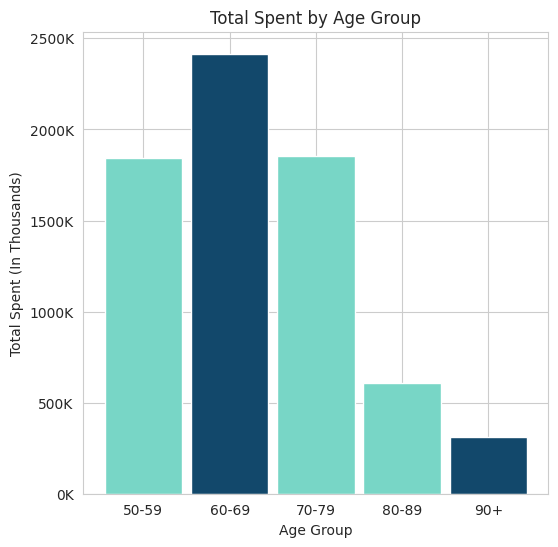

In [ ]:
# Bar Graph showing the total spent per age group
age_group_agg['transaction_amount_thousands'] = age_group_agg['transaction_amount'] / 1000  # Convert to millions

# Create the bar graph
plt.figure(figsize=(6, 6))
plt.bar(age_group_agg['age_group'], age_group_agg['transaction_amount_thousands'], color=['#78d6c6', '#12486b', '#78d6c6'], width = 0.9)
plt.xlabel('Age Group')
plt.ylabel('Total Spent (In Thousands)')
plt.title('Total Spent by Age Group')

# Define the formatter function for millions
def thousands_formatter(x, pos):
    return f'{x:.0f}K'

# Apply the formatter to the y-axis
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

##### **Binned Age Group Comparison based on Average Spent**

In [ ]:
# Define age groups
bins = [43, 59, 78, np.inf]
labels = ['Gen X (43-58)', 'Boomers (59-77)', 'Post War (78+)']

# Use pd.cut to create a new column 'age_group'
df_age_group['age_group'] = pd.cut(df_age_group['age'], bins=bins, labels=labels, right=False)

df_age_group.head()

,cc_num,acct_num,transaction_date,transaction_num,transaction_amount,category,gender,age,birth_date,job,city,city_population,age_group,year,month
0,676000000000.0,798000000000,2020-02-10 05:53:31,a72eaa86b043eed95b25bbb25b3153a1,68.88,shopping,M,64.0,1958-12-12,Chartered loss adjuster,Dasmarinas,659019,Boomers (59-77),2020,2
1,3520000000000000.0,968000000000,2020-05-31 05:29:28,060d12f91c13871a13963041736a4702,50.06,entertainment,M,53.0,1970-08-31,"Administrator, charities/voluntary organisations",Digos,169393,Gen X (43-58),2020,5
2,4.14e+18,628000000000,2020-03-29 05:52:37,18aafb6098ab0923886c0ac83592ef8d,105.44,food_dining,M,70.0,1953-07-23,Financial controller,Calapan,133893,Boomers (59-77),2020,3
3,4870000000000000.0,863000000000,2021-02-11 17:15:04,45bbe714e51ab8a375454d39a190b0cb,38.61,food_dining,M,59.0,1964-07-18,N/A,San Fernando,121812,Boomers (59-77),2021,2
4,4720000000000000.0,257000000000,2020-09-28 08:35:59,c20ee88b451f637bc6893b7460e9fee0,82.69,gas_transport,M,68.0,1954-11-01,Dance movement psychotherapist,Laoag,111125,Boomers (59-77),2020,9


In [ ]:
# Group by age group and get the average spend, number of account numbers, number of transactions
avg_transaction_count_and_avg_spend_per_age_group = df_age_group.groupby('age_group').agg({'transaction_amount': 'mean', 'acct_num': 'nunique', 'transaction_num': 'nunique'})

age_group_ave_agg = avg_transaction_count_and_avg_spend_per_age_group.reset_index()

display(age_group_ave_agg)

,age_group,transaction_amount,acct_num,transaction_num
0,Gen X (43-58),69.870723,19,19877
1,Boomers (59-77),70.347450,54,60288
2,Post War (78+),70.545837,19,19835


In [ ]:
#Get the average frequency ofeach age group
age_group_ave_agg['avg_frequency'] = age_group_ave_agg['transaction_num'] / age_group_ave_agg['acct_num']

age_group_ave_agg.head()

,age_group,transaction_amount,acct_num,transaction_num,avg_frequency
0,Gen X (43-58),69.870723,19,19877,1046.157895
1,Boomers (59-77),70.347450,54,60288,1116.444444
2,Post War (78+),70.545837,19,19835,1043.947368


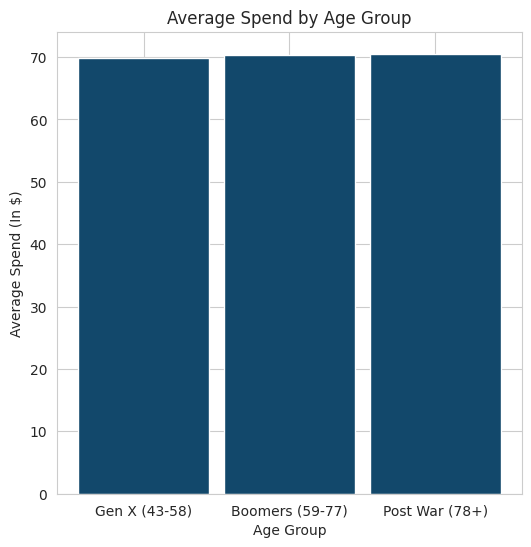

In [ ]:
# Create the bar graph showing average spend
plt.figure(figsize=(6, 6))
plt.bar(age_group_ave_agg['age_group'], age_group_ave_agg['transaction_amount'], color=['#12486b', '#12486B', '#12486b'], width = 0.9)
plt.xlabel('Age Group')
plt.ylabel('Average Spend (In $)')
plt.title('Average Spend by Age Group')

# # Define the formatter function for millions
# def thousands_formatter(x, pos):
#     return f'{x:.0f}K'

# # Apply the formatter to the y-axis
# formatter = FuncFormatter(thousands_formatter)
# plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

##### **Top 5 Accounts based on Total Amount Spent**

In [ ]:
# Top 5 Accounts by Total Amount Spent (gender-neutral)
acct_num_by_total_amount_spent = df_cleaned.groupby('acct_num')['transaction_amount'].sum()
display(acct_num_by_total_amount_spent.sort_values(ascending=False).nlargest(5))

acct_num
902000000000    276055.35
845000000000    228798.66
233000000000    203177.81
488000000000    164156.85
664000000000    162070.92
Name: transaction_amount, dtype: float64

###### **Top 5 Accounts for Males**

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].groupby('acct_num').transaction_amount.sum().sort_values(ascending=False)

acct_num
902000000000    276055.35
845000000000    228798.66
233000000000    203177.81
488000000000    164156.85
664000000000    162070.92
                  ...    
293000000000      4565.30
644000000000      3458.42
224000000000      3410.77
460000000000      2919.20
169000000000      2814.60
Name: transaction_amount, Length: 84, dtype: float64

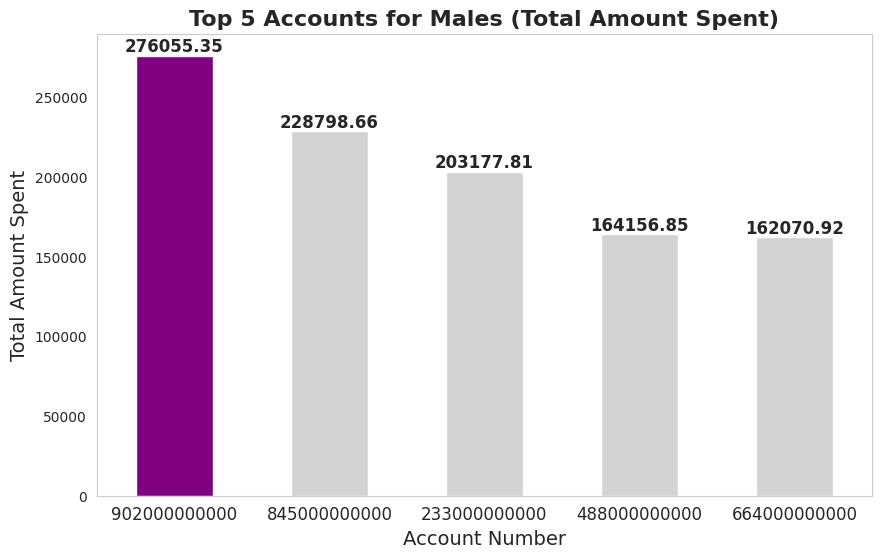

In [ ]:
# Group the data by 'gender' and 'acct_num', then calculate the total amount spent per acct_num for Males
male_acct_num_total = df_cleaned[df_cleaned['gender'] == 'M'].groupby('acct_num')['transaction_amount'].sum()

# Sort the data in descending order of total amount spent
male_acct_num_total = male_acct_num_total.sort_values(ascending=False)

# Select the top 5 categories
top_5_male_acct_num = male_acct_num_total.head(5)

# Create a bar graph with greyed out bars except the top one
plt.figure(figsize=(10, 6))
colors = ['lightgrey' if category != top_5_male_acct_num.index[0] else 'purple' for category in top_5_male_acct_num.index]
bars = top_5_male_acct_num.plot(kind='bar', color=colors)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Total Amount Spent', fontsize=14)
plt.title('Top 5 Accounts for Males (Total Amount Spent)', fontsize=16, fontweight='bold')

# Add labels on top of the bars
for i, v in enumerate(top_5_male_acct_num):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

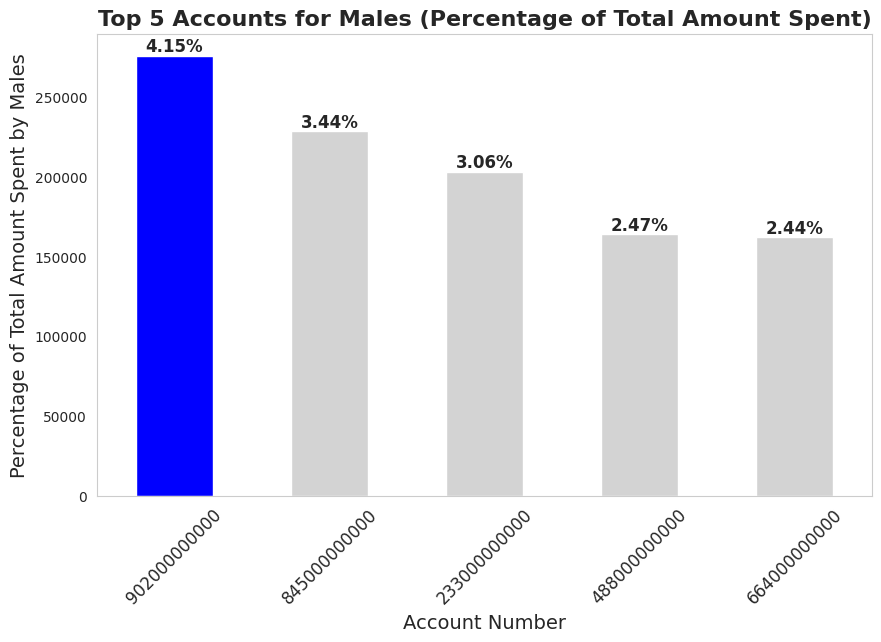

In [ ]:
# Group the data by 'gender' and 'category', then calculate the total amount spent per category for Males
male_acct_num_total = df_cleaned[df_cleaned['gender'] == 'M'].groupby('acct_num')['transaction_amount'].sum()

# Calculate the total amount spent by males
total_male_spending = male_acct_num_total.sum()

# Sort the data in descending order of total amount spent
male_acct_num_total = male_acct_num_total.sort_values(ascending=False)

# Select the top 5 Accounts
top_5_male_acct_num = male_acct_num_total.head(5)

# Calculate the percentage of total amount spent for each account
percentage_of_total = (top_5_male_acct_num / total_male_spending) * 100

# Create a bar graph with percentage labels
plt.figure(figsize=(10, 6))
colors = ['blue', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey']
bars = top_5_male_acct_num.plot(kind='bar', color=colors)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Percentage of Total Amount Spent by Males', fontsize=14)
plt.title('Top 5 Accounts for Males (Percentage of Total Amount Spent)', fontsize=16, fontweight='bold')

# Add percentage labels on top of the bars
for i, v in enumerate(top_5_male_acct_num):
    plt.text(i, v, f'{percentage_of_total.iloc[i]:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=45, fontsize=12)
plt.show()


###### **Top 5 Accounts for Females**

In [ ]:
df_cleaned[df_cleaned['gender']=='F'].groupby('acct_num').transaction_amount.sum().sort_values(ascending=False)

acct_num
404000000000    142158.97
994000000000     91710.43
946000000000     51821.64
668000000000     46729.55
878000000000     44385.74
581000000000      2194.06
Name: transaction_amount, dtype: float64

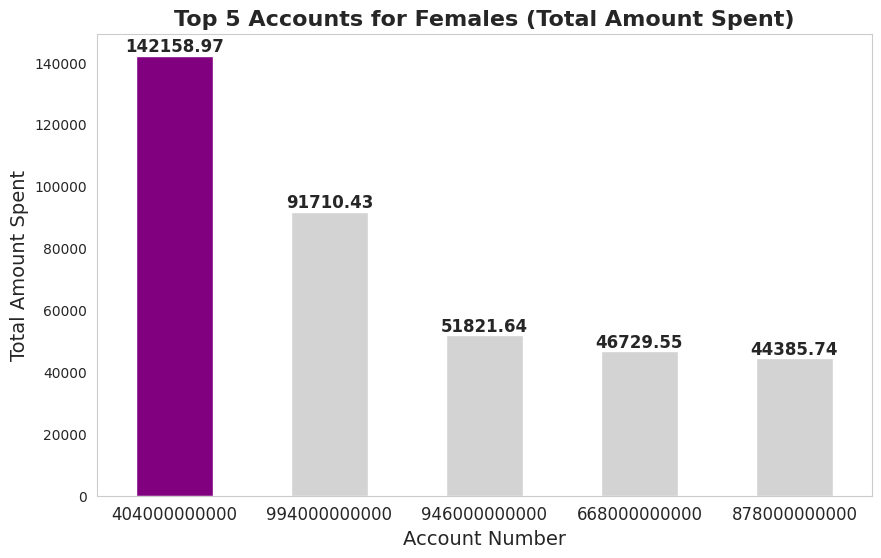

In [ ]:
# Group the data by 'gender' and 'acct_num', then calculate the total amount spent per acct_num for Females
female_acct_num_total = df_cleaned[df_cleaned['gender'] == 'F'].groupby('acct_num')['transaction_amount'].sum()

# Sort the data in descending order of total amount spent
female_acct_num_total = female_acct_num_total.sort_values(ascending=False)

# Select the Top 5 Accounts
top_5_female_acct_num = female_acct_num_total.head(5)

# Create a bar graph with greyed out bars except the top one
plt.figure(figsize=(10, 6))
colors = ['lightgrey' if category != top_5_female_acct_num.index[0] else 'purple' for category in top_5_female_acct_num.index]
bars = top_5_female_acct_num.plot(kind='bar', color=colors)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Total Amount Spent', fontsize=14)
plt.title('Top 5 Accounts for Females (Total Amount Spent)', fontsize=16, fontweight='bold')

# Add labels on top of the bars
for i, v in enumerate(top_5_female_acct_num):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

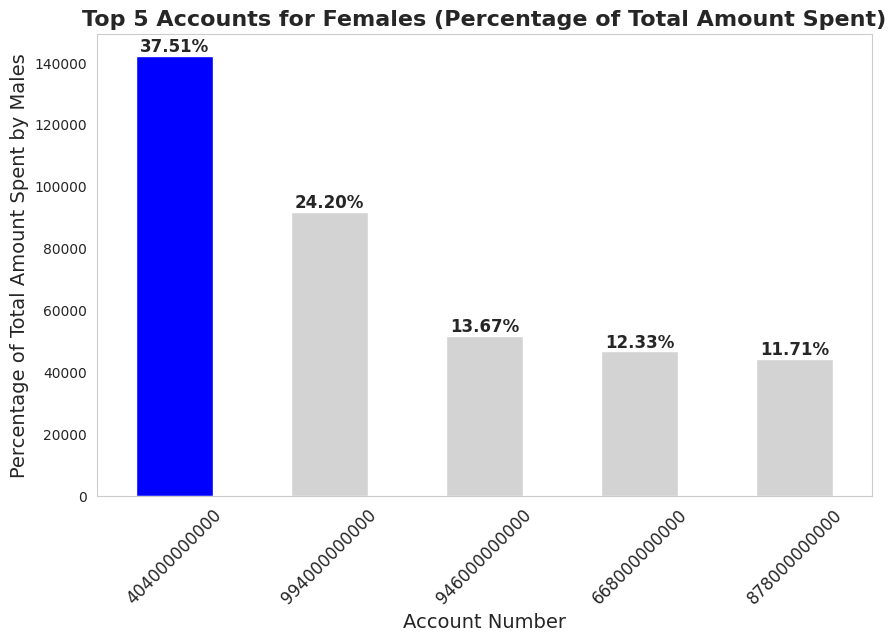

In [ ]:
# Group the data by 'gender' and 'category', then calculate the total amount spent per category for Females
female_acct_num_total = df_cleaned[df_cleaned['gender'] == 'F'].groupby('acct_num')['transaction_amount'].sum()

# Calculate the total amount spent by males
total_female_spending = female_acct_num_total.sum()

# Sort the data in descending order of total amount spent
female_acct_num_total = female_acct_num_total.sort_values(ascending=False)

# Select the Top 5 Accounts
top_5_female_acct_num = female_acct_num_total.head(5)

# Calculate the percentage of total amount spent for each account
percentage_of_total = (top_5_female_acct_num / total_female_spending) * 100

# Create a bar graph with percentage labels
plt.figure(figsize=(10, 6))
colors = ['blue', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey']
bars = top_5_female_acct_num.plot(kind='bar', color=colors)
plt.xlabel('Account Number', fontsize=14)
plt.ylabel('Percentage of Total Amount Spent by Males', fontsize=14)
plt.title('Top 5 Accounts for Females (Percentage of Total Amount Spent)', fontsize=16, fontweight='bold')

# Add percentage labels on top of the bars
for i, v in enumerate(top_5_female_acct_num):
    plt.text(i, v, f'{percentage_of_total.iloc[i]:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=45, fontsize=12)
plt.show()

##### **Top 5 Categories based on Total Amount Spent**

In [ ]:
# Top 5 Categories by Total Amount Spent (gender-neutral)
categories_by_total_amount_spent = df_cleaned.groupby('category')['transaction_amount'].sum()
display(categories_by_total_amount_spent.sort_values(ascending=False).nlargest(5))

category
shopping         1125051.31
grocery          1023827.01
kids_pets         731337.88
gas_transport     648194.37
misc              631923.52
Name: transaction_amount, dtype: float64

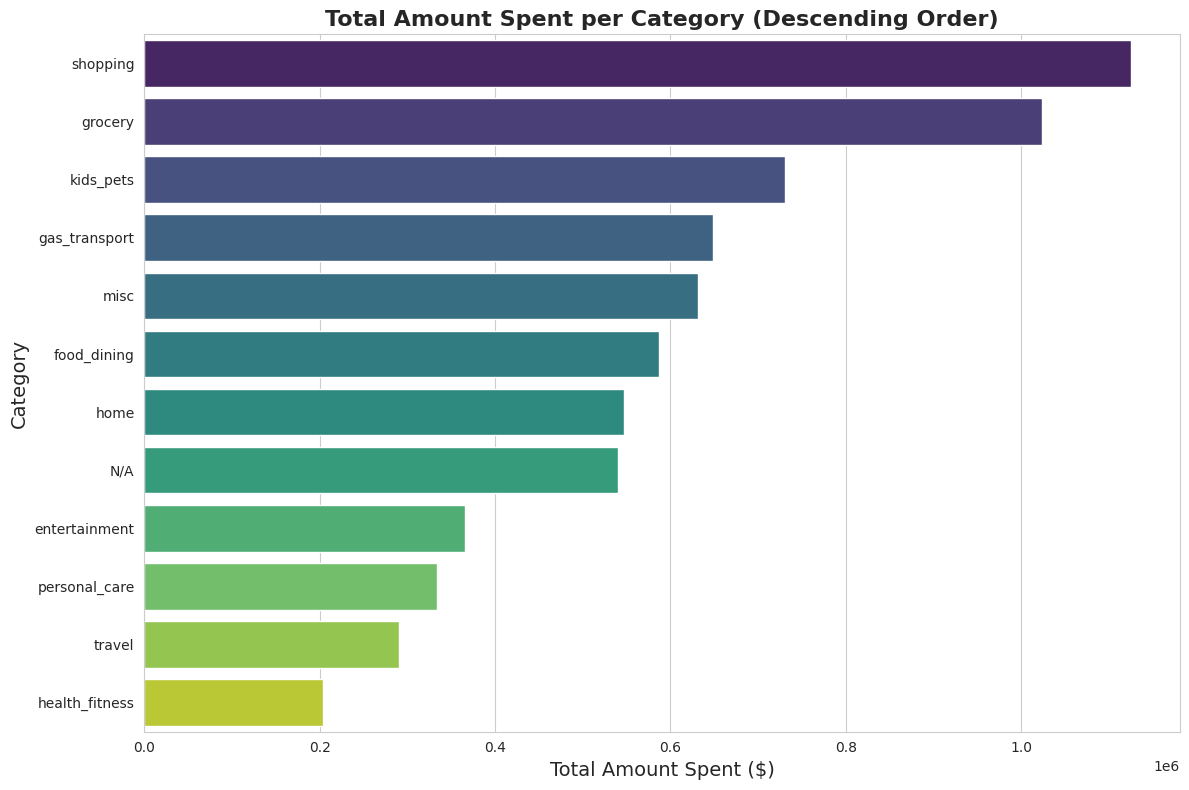

In [ ]:
# Group by 'category' and calculate the total amount spent for each category
category_total_amount = df_cleaned.groupby('category')['transaction_amount'].sum().reset_index()

# Sort the result in descending order based on total amount spent
category_total_amount = category_total_amount.sort_values(by='transaction_amount', ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the total amount spent per category in descending order
ax = sns.barplot(x='transaction_amount', y='category', data=category_total_amount, palette="viridis")

# Customize the plot
plt.title('Total Amount Spent per Category (Descending Order)', fontsize=16, fontweight='bold')
plt.xlabel('Total Amount Spent ($)', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

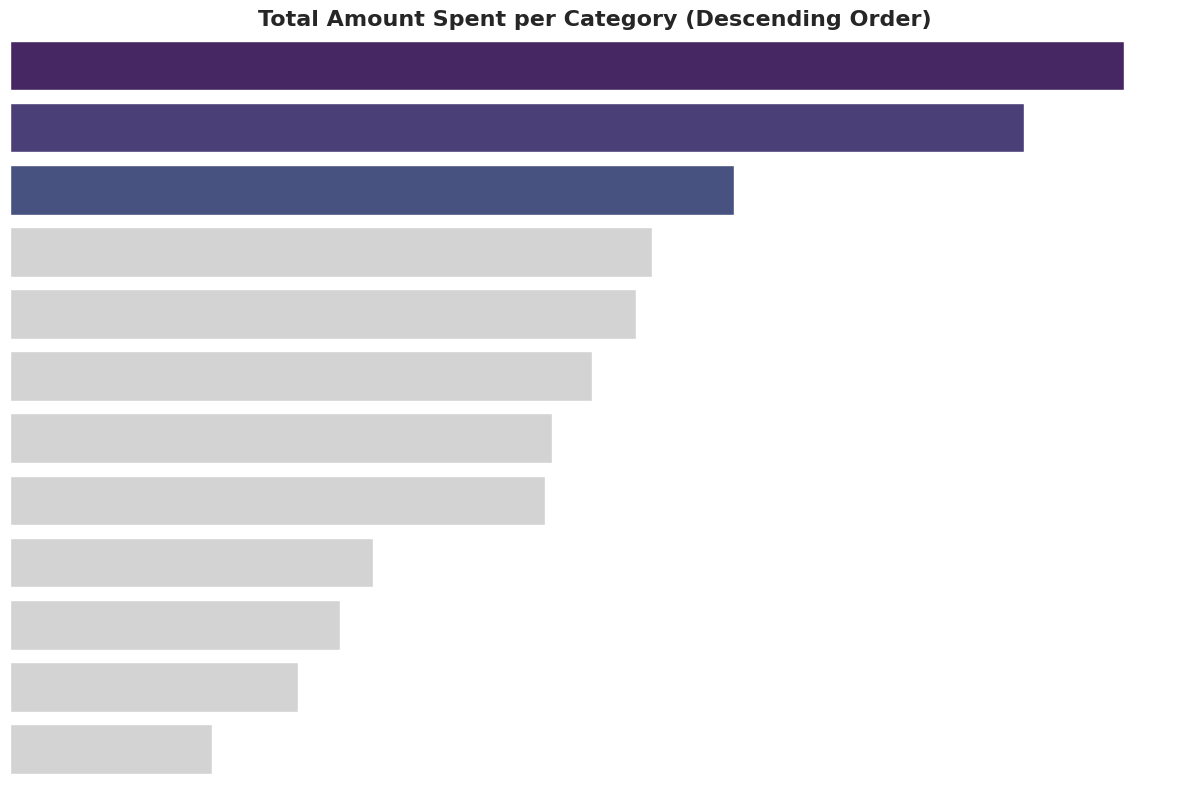

In [ ]:
# Group by 'category' and calculate the total amount spent for each category
category_total_amount = df_cleaned.groupby('category')['transaction_amount'].sum().reset_index()

# Sort the result in descending order based on total amount spent
category_total_amount = category_total_amount.sort_values(by='transaction_amount', ascending=False)

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the total amount spent per category in descending order
ax = sns.barplot(x='transaction_amount', y='category', data=category_total_amount, palette="viridis")

# Highlight the top 3 categories
top_categories = category_total_amount.iloc[:3]
for i, bar in enumerate(ax.patches):
    if category_total_amount.iloc[i]['category'] not in top_categories['category'].tolist():
        bar.set_facecolor('lightgrey')

# Customize the plot
plt.title('Total Amount Spent per Category (Descending Order)', fontsize=16, fontweight='bold')
plt.xlabel('Total Amount Spent ($)', fontsize=14)
plt.ylabel('Category', fontsize=14)

# Hide grids and labels
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

###### **Top 5 Categories for Males**

In [ ]:
df_cleaned['category'].unique()

array(['shopping', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'N/A', 'personal_care', 'grocery', 'travel',
       'misc', 'health_fitness'], dtype=object)

In [ ]:
df_cleaned[df_cleaned['gender']=='M'].groupby('category').transaction_amount.sum().sort_values(ascending=False)

category
shopping          1067146.97
grocery            962829.23
kids_pets          688584.18
gas_transport      612866.10
misc               602974.64
food_dining        552784.94
home               516051.76
N/A                512789.43
entertainment      344319.36
personal_care      314951.70
travel             283205.94
health_fitness     191699.46
Name: transaction_amount, dtype: float64

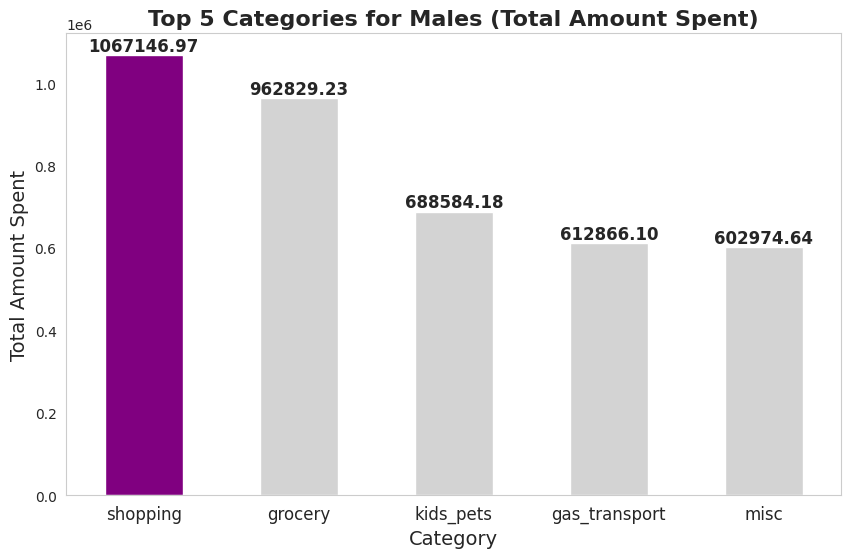

In [ ]:
# Group the data by 'gender' and 'category', then calculate the total amount spent per category for males
male_category_total = df_cleaned[df_cleaned['gender'] == 'M'].groupby('category')['transaction_amount'].sum()

# Sort the data in descending order of total amount spent
male_category_total = male_category_total.sort_values(ascending=False)

# Select the top 5 categories
top_5_male_categories = male_category_total.head(5)

# Create a bar graph with greyed out bars except the top one
plt.figure(figsize=(10, 6))
colors = ['lightgrey' if category != top_5_male_categories.index[0] else 'purple' for category in top_5_male_categories.index]
bars = top_5_male_categories.plot(kind='bar', color=colors)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Total Amount Spent', fontsize=14)
plt.title('Top 5 Categories for Males (Total Amount Spent)', fontsize=16, fontweight='bold')

# Add labels on top of the bars
for i, v in enumerate(top_5_male_categories):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

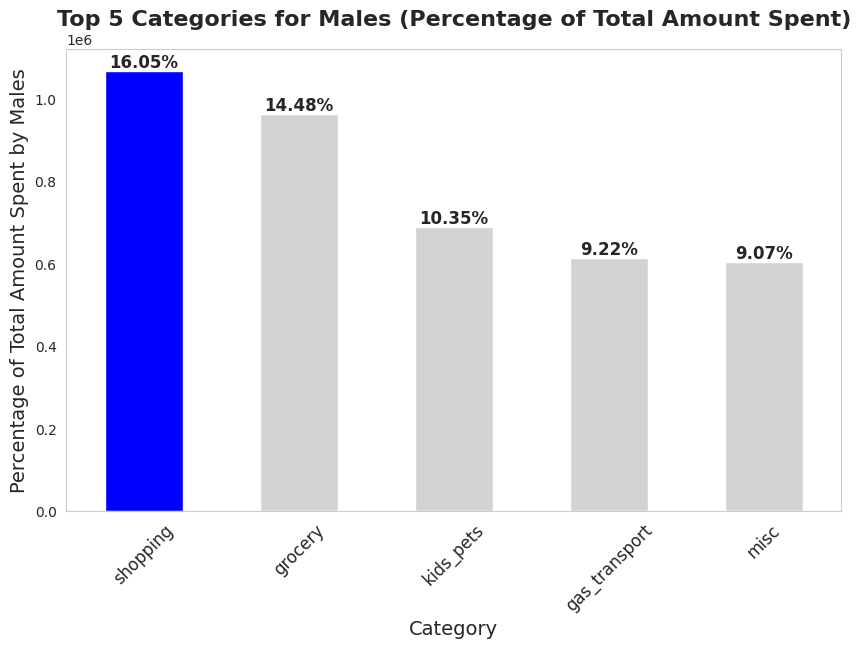

In [ ]:

# Group the data by 'gender' and 'category', then calculate the total amount spent per category for males
male_category_total = df_cleaned[df_cleaned['gender'] == 'M'].groupby('category')['transaction_amount'].sum()

# Calculate the total amount spent by males
total_male_spending = male_category_total.sum()

# Sort the data in descending order of total amount spent
male_category_total = male_category_total.sort_values(ascending=False)

# Select the top 5 categories
top_5_male_categories = male_category_total.head(5)

# Calculate the percentage of total amount spent for each category
percentage_of_total = (top_5_male_categories / total_male_spending) * 100

# Create a bar graph with percentage labels
plt.figure(figsize=(10, 6))
colors = ['blue', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey']
bars = top_5_male_categories.plot(kind='bar', color=colors)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Percentage of Total Amount Spent by Males', fontsize=14)
plt.title('Top 5 Categories for Males (Percentage of Total Amount Spent)', fontsize=16, fontweight='bold')

# Add percentage labels on top of the bars
for i, v in enumerate(top_5_male_categories):
    plt.text(i, v, f'{percentage_of_total.iloc[i]:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=45, fontsize=12)
plt.show()


In [ ]:
df_cleaned['transaction_amount'].sum()

7029204.099999999

###### **Top 5 Categories for Females**

In [ ]:
df_cleaned['category'].unique()

array(['shopping', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'N/A', 'personal_care', 'grocery', 'travel',
       'misc', 'health_fitness'], dtype=object)

In [ ]:
df_cleaned[df_cleaned['gender']=='F'].groupby('category').transaction_amount.sum().sort_values(ascending=False)

category
grocery           60997.78
shopping          57904.34
kids_pets         42753.70
gas_transport     35328.27
food_dining       34797.66
home              30945.78
misc              28948.88
N/A               27507.88
entertainment     21843.65
personal_care     18446.11
health_fitness    12289.33
travel             7237.01
Name: transaction_amount, dtype: float64

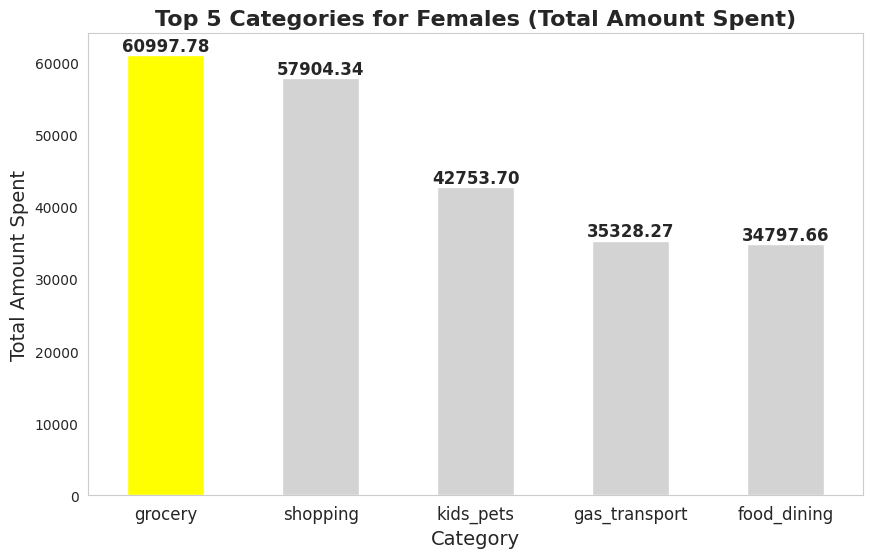

In [ ]:
# Group the data by 'gender' and 'category', then calculate the total amount spent per category for males
female_category_total = df_cleaned[df_cleaned['gender'] == 'F'].groupby('category')['transaction_amount'].sum()

# Sort the data in descending order of total amount spent
female_category_total = female_category_total.sort_values(ascending=False)

# Select the top 5 categories
top_5_female_categories = female_category_total.head(5)

# Create a bar graph with greyed out bars except the top one
plt.figure(figsize=(10, 6))
colors = ['lightgrey' if category != top_5_female_categories.index[0] else 'yellow' for category in top_5_female_categories.index]
bars = top_5_female_categories.plot(kind='bar', color=colors)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Total Amount Spent', fontsize=14)
plt.title('Top 5 Categories for Females (Total Amount Spent)', fontsize=16, fontweight='bold')

# Add labels on top of the bars
for i, v in enumerate(top_5_female_categories):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=0, fontsize=12)
plt.show()

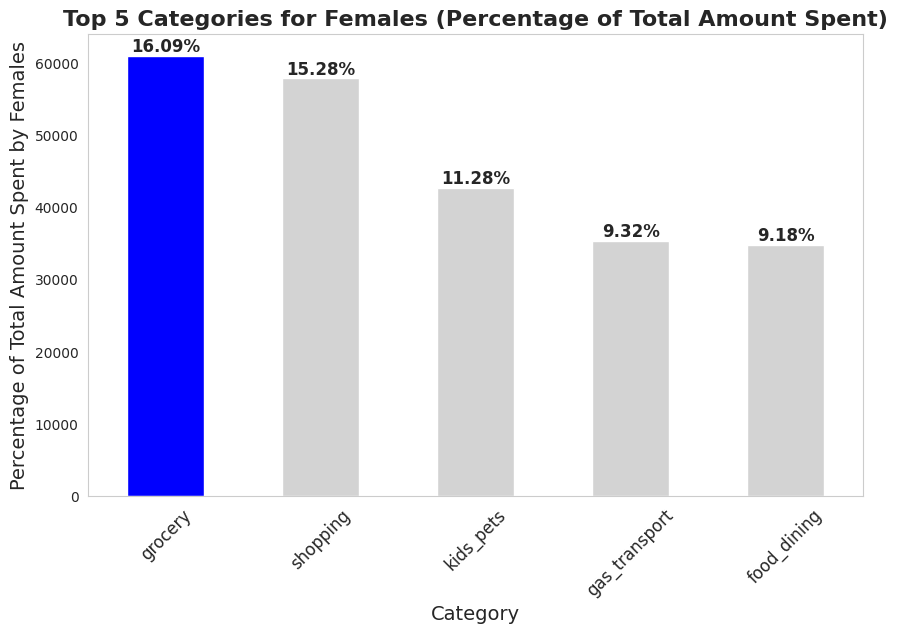

In [ ]:
# Group the data by 'gender' and 'category', then calculate the total amount spent per category for males
female_category_total = df_cleaned[df_cleaned['gender'] == 'F'].groupby('category')['transaction_amount'].sum()

# Calculate the total amount spent by males
total_female_spending = female_category_total.sum()

# Sort the data in descending order of total amount spent
female_category_total = female_category_total.sort_values(ascending=False)

# Select the top 5 categories
top_5_female_categories = female_category_total.head(5)

# Calculate the percentage of total amount spent for each category
percentage_of_total = (top_5_female_categories / total_female_spending) * 100

# Create a bar graph with percentage labels
plt.figure(figsize=(10, 6))
colors = ['blue', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey']
bars = top_5_female_categories.plot(kind='bar', color=colors)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Percentage of Total Amount Spent by Females', fontsize=14)
plt.title('Top 5 Categories for Females (Percentage of Total Amount Spent)', fontsize=16, fontweight='bold')

# Add percentage labels on top of the bars
for i, v in enumerate(top_5_female_categories):
    plt.text(i, v, f'{percentage_of_total.iloc[i]:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Remove grid lines
plt.grid(False)

# Show the bar graph
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [ ]:
df_cleaned['transaction_amount'].sum()

7029204.099999999

In [ ]:
total_male_spending + total_female_spending

7029204.1

##### **Top 5 Categories per Age Bin based on Total Amount Spent**

In [ ]:
df_cleaned['category'].unique()

array(['shopping', 'entertainment', 'food_dining', 'gas_transport',
       'home', 'kids_pets', 'N/A', 'personal_care', 'grocery', 'travel',
       'misc', 'health_fitness'], dtype=object)

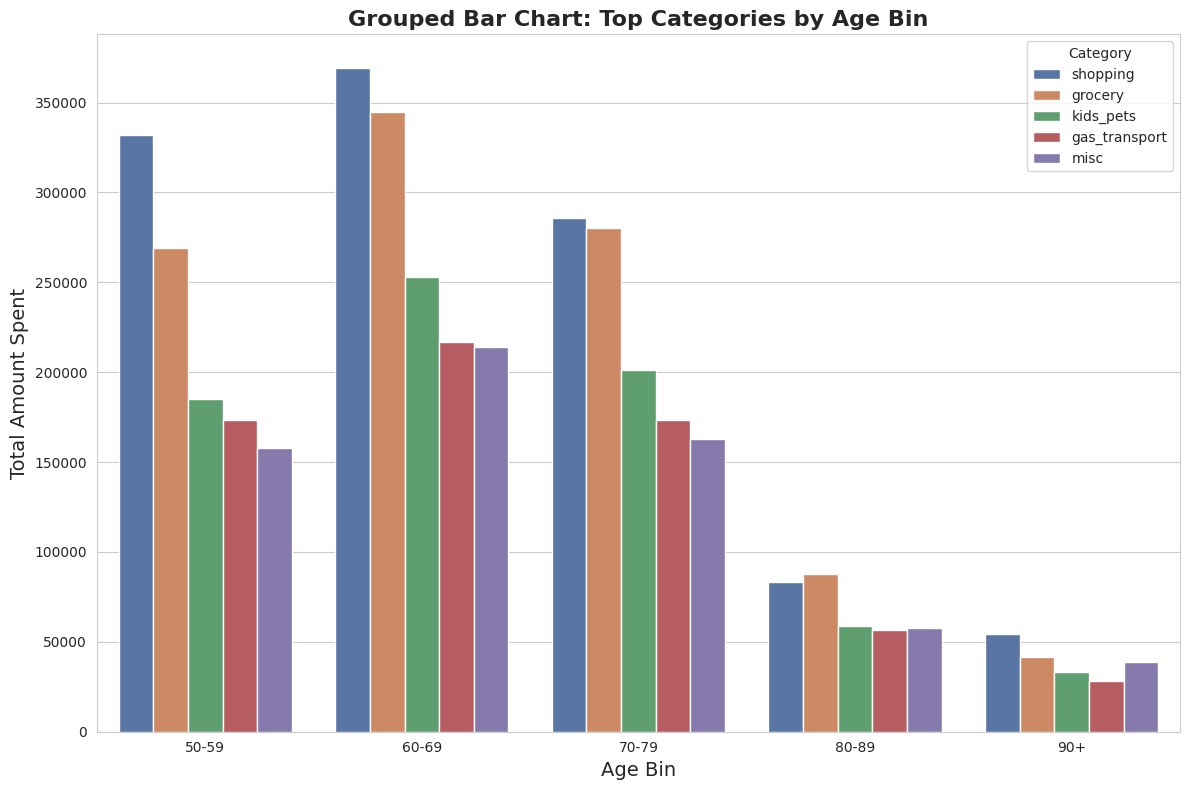

In [ ]:
# Define the age bins
age_bins = [50, 60, 70, 80, 90, df_cleaned['age'].max() + 3]  # Using the maximum age as upper limit..may +3 just to make the intervals consistent kase ang max is 97
age_labels = ['50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'age_group' by applying age bins
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

# Select the top categories by total amount spent for each age group
top_categories_per_age = df_cleaned.groupby(['age_group', 'category'])['transaction_amount'].sum().reset_index()

# Sort the categories in descending order of total amount spent within each age group
top_categories_per_age.sort_values(by=['age_group', 'transaction_amount'], ascending=[True, False], inplace=True)

# Select the top 5 categories for each age group
top_5_categories_per_age = top_categories_per_age.groupby('age_group').head(5)

# Define a custom pastel color palette
deep_colors = sns.color_palette("deep", n_colors=len(top_5_categories_per_age['category'].unique()))

# Create a grouped bar chart using Seaborn with pastel colors
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot the top categories for each age group with pastel colors
ax = sns.barplot(x='age_group', y='transaction_amount', hue='category', data=top_5_categories_per_age, palette=deep_colors, errorbar=None)

# Customize the plot
# plt.title('Grouped Bar Chart: Top Categories by Age Bin (Total Amount Spent, Descending Order)', fontsize=16, fontweight='bold')
plt.title('Grouped Bar Chart: Top Categories by Age Bin', fontsize=16, fontweight='bold')
plt.xlabel('Age Bin', fontsize=14)
plt.ylabel('Total Amount Spent', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Category')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Define the age bins
age_bins = [50, 60, 70, 80, 90, df_cleaned['age'].max() + 3]  # Using the maximum age as upper limit..may +3 just to make the intervals consistent kase ang max is 97
age_labels = ['50-59', '60-69', '70-79', '80-89', '90+']

# Create a new column 'age_group' by applying age bins
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=age_bins, labels=age_labels)

# Select the top 5 categories by total amount spent for each age group
top_categories_per_age = df_cleaned.groupby(['age_group', 'category'])['transaction_amount'].sum().reset_index()

# Sort the categories in descending order of total amount spent within each age group
top_categories_per_age = top_categories_per_age.sort_values(by=['age_group', 'transaction_amount'], ascending=[True, False])

# Use groupby and head to select the top 5 categories for each age group
top_5_categories_per_age = top_categories_per_age.groupby('age_group').head(5)

# Reset the index of the DataFrame
top_5_categories_per_age = top_5_categories_per_age.reset_index(drop=True)

# Print the DataFrame
print(top_5_categories_per_age)

   age_group       category  transaction_amount
0      50-59       shopping           332125.41
1      50-59        grocery           269370.31
2      50-59      kids_pets           184959.23
3      50-59  gas_transport           173482.48
4      50-59           misc           157994.92
5      60-69       shopping           369519.37
6      60-69        grocery           344730.73
7      60-69      kids_pets           253185.89
8      60-69  gas_transport           216752.36
9      60-69           misc           214149.18
10     70-79       shopping           285890.95
11     70-79        grocery           280095.89
12     70-79      kids_pets           201474.13
13     70-79  gas_transport           173344.13
14     70-79           misc           163040.79
15     80-89        grocery            87795.15
16     80-89       shopping            83410.28
17     80-89      kids_pets            58730.19
18     80-89           misc            57785.28
19     80-89  gas_transport            5

##### **Binned Total Amount Spent per Transaction**

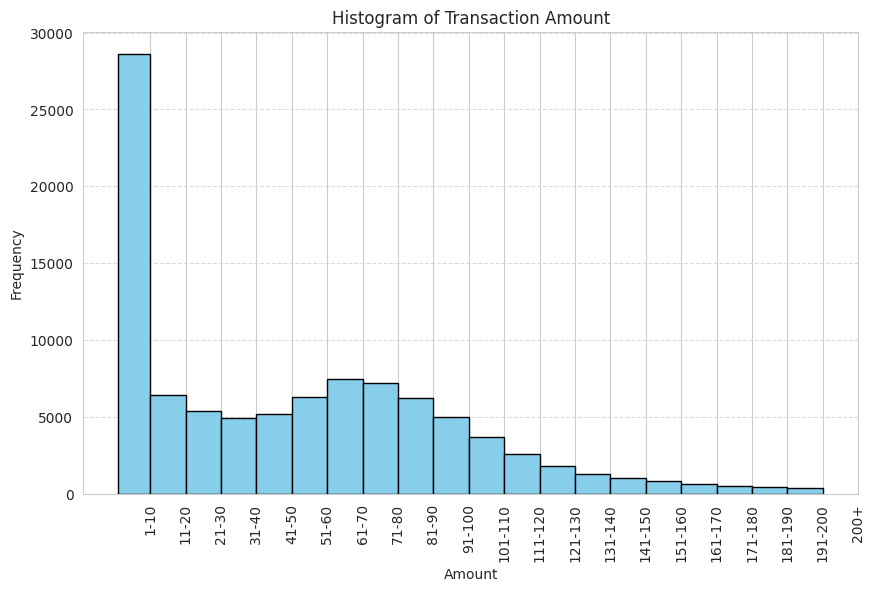

In [ ]:
# Define custom amount bins
amount_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, float('inf')]  # The last bin is for values greater than 200

# Create a histogram for the 'transaction_amount' column with custom bins
plt.figure(figsize=(10, 6))
plt.hist(df_cleaned['transaction_amount'], bins=amount_bins, color='skyblue', edgecolor='black')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Transaction Amount')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Label the x-axis with bin ranges
bin_labels = ['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-120', '121-130', '131-140', '141-150', '151-160', '161-170', '171-180', '181-190', '191-200', '200+']
plt.xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210], bin_labels, rotation=90)  # Updated the ticks to match labels

# Show the histogram
plt.show()

##### **Outlier Detection & Removal on transaction_amount**


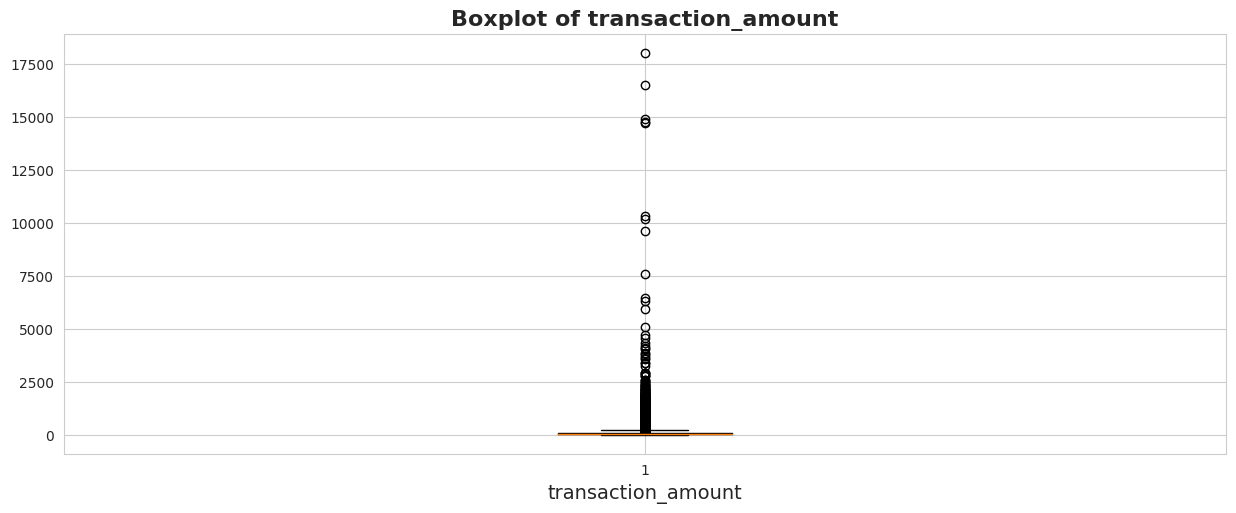

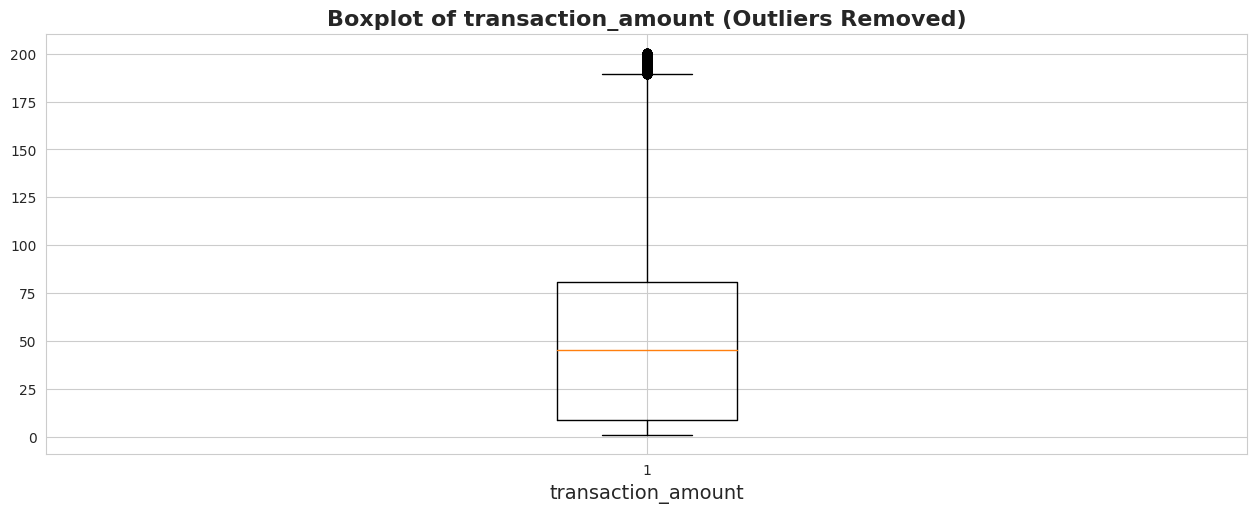

In [ ]:
# Detect outliers in 'transaction_amount' by visualizing using a boxplot
plt.figure(figsize=(15, 12))
plt.subplot(2,1,1)
plt.boxplot(df_cleaned['transaction_amount'])
plt.title('Boxplot of transaction_amount', fontsize=16, fontweight='bold')
plt.xlabel('transaction_amount', fontsize=14)
plt.show()

# Calculate quartiles and IQR of 'transaction_amount'
Q1 = df_cleaned['transaction_amount'].quantile(0.25)
Q3 = df_cleaned['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of 'transaction_amount' for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in 'transaction_amount' and create a new DataFrame
condition = (df_cleaned['transaction_amount'] >= lower_bound) & (df_cleaned['transaction_amount'] <= upper_bound)
df_cleaned_no_outliers_in_transaction_amount = df_cleaned[condition]

# Visualize using a boxplot
plt.figure(figsize=(15.5, 12))
plt.subplot(2,1,2)
plt.boxplot(df_cleaned_no_outliers_in_transaction_amount['transaction_amount'])
plt.title('Boxplot of transaction_amount (Outliers Removed)', fontsize=16, fontweight='bold')
plt.xlabel('transaction_amount', fontsize=14)
plt.show()

##### **Outlier Detection & Removal on transaction_amount per age_group**


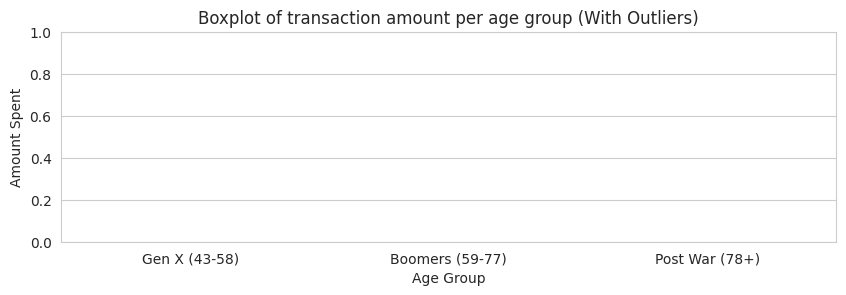

age_group
Gen X (43-58)      0
Boomers (59-77)    0
Post War (78+)     0
Name: transaction_num, dtype: int64
age_group
Gen X (43-58)      0
Boomers (59-77)    0
Post War (78+)     0
Name: transaction_num, dtype: int64


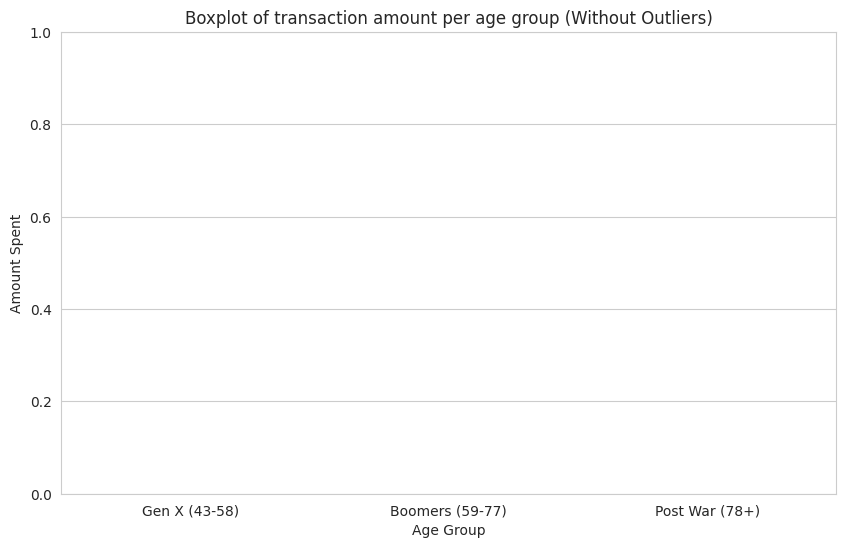

In [ ]:
# Convert 'age_group' column to categorical for proper ordering
df_age_group['age_group'] = pd.Categorical(df_age_group['age_group'], categories=['Gen X (43-58)', 'Boomers (59-77)', 'Post War (78+)'], ordered=True)

# Create the boxplot
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
sns.boxplot(x='age_group', y='transaction_amount', data=df_age_group)
plt.xlabel('Age Group')
plt.ylabel('Amount Spent')
plt.title('Boxplot of transaction amount per age group (With Outliers)')
plt.show()

# Calculate quartiles and IQR of 'amt'
Q1 = df_cleaned['transaction_amount'].quantile(0.25)
Q3 = df_cleaned['transaction_amount'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds of 'amt' for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers in 'amt' and create a new DataFrame
condition = (df_age_group['transaction_amount'] >= lower_bound) & (df_age_group['transaction_amount'] <= upper_bound)
df_cleaned_no_outliers_in_transaction_amount = df_age_group[condition]

print(df_age_group.groupby('age_group')['transaction_num'].nunique())
print(df_cleaned_no_outliers_in_transaction_amount.groupby('age_group')['transaction_num'].nunique())

# Visualize using a boxplot
plt.figure(figsize=(10, 6))
#plt.subplot(2,1,2)
sns.boxplot(x='age_group', y='transaction_amount', data=df_cleaned_no_outliers_in_transaction_amount)
plt.xlabel('Age Group')
plt.ylabel('Amount Spent')
plt.title('Boxplot of transaction amount per age group (Without Outliers)')
plt.show()

# **Step 4: RFM Segmentation of Customers**




**Recency-Frequency-Monetary**
    
RFM analysis segments customers by the frequency and value of purchases and identify those customers who spend the most money.

* Recency — how long it’s been since a customer bought something from us.
* Frequency — how often a customer buys from us
* Monetary value — the total value of purchases a customer has made</b>

NOTE: last transaction date is 2021–12–07, this will be used to calculate Recency

In [ ]:
snapshot_date = max(df_cleaned.transaction_date) + timedelta(days=1)
snapshot_date

Timestamp('2021-12-07 23:50:42')

In [ ]:
# Aggregate data on a customer level and compute rfm
df_cleaned_agg = df_cleaned.groupby(['acct_num']).agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days,
    'transaction_num': 'count',
    'transaction_amount': 'sum'
})

In [ ]:
# Rename columns for easier interpretation
df_cleaned_agg.rename(columns =
 {'transaction_date': 'Recency',
  'transaction_num': 'Frequency',
  'transaction_amount': 'Monetary'}, inplace=True)

df_cleaned_agg[['Recency', 'Frequency', 'Monetary']]

,Recency,Frequency,Monetary
acct_num,,,
124000000000,1,2116,139457.00
138000000000,377,7,4809.37
169000000000,118,9,2814.60
170000000000,1,2122,147377.96
201000000000,2,714,53261.97
...,...,...,...
969000000000,1,711,45602.00
971000000000,1,2118,157170.23
989000000000,2,712,50219.09


In [ ]:
# Set the random state to a specific value
R = np.random.RandomState(3)

# Generate a random number between 0 and 1
print(R.rand())

0.5507979025745755


In [ ]:
# Add a small amount of random noise to the 'Recency' column
df_cleaned_agg['Recency'] += R.rand(len(df_cleaned_agg)) * 1e-9

In [ ]:
# Create Recency Quartile

# Assign these labels to four equal percentile groups
recency_groups = pd.qcut(df_cleaned_agg['Recency'],
                                               q=4,
                                               labels=[4, 3, 2, 1])

# Create new column R
df_cleaned_agg = df_cleaned_agg.assign(R=recency_groups.values)
df_cleaned_agg.head()

,Recency,Frequency,Monetary,R
acct_num,,,,
124000000000,1.0,2116,139457.00,3
138000000000,377.0,7,4809.37,1
169000000000,118.0,9,2814.60,1
170000000000,1.0,2122,147377.96,2
201000000000,2.0,714,53261.97,2


In [ ]:
# Create Frequency Quartile

# Assign these labels to four equal percentile groups
frequency_groups = pd.qcut(df_cleaned_agg['Frequency'],
                                                   q=4,
                                                   labels=[1, 2, 3, 4])

# Create new column F
df_cleaned_agg = df_cleaned_agg.assign(F=frequency_groups.values)
df_cleaned_agg.head()

,Recency,Frequency,Monetary,R,F
acct_num,,,,,
124000000000,1.0,2116,139457.00,3,4
138000000000,377.0,7,4809.37,1,1
169000000000,118.0,9,2814.60,1,1
170000000000,1.0,2122,147377.96,2,4
201000000000,2.0,714,53261.97,2,2


In [ ]:
# Create Monetary Quartile

# Assign these labels to four equal percentile groups
monetary_groups = pd.qcut(df_cleaned_agg['Monetary'],
                                                 q=4,
                                                 labels=[1, 2, 3, 4])

# Create new column M
df_cleaned_agg = df_cleaned_agg.assign(M=monetary_groups)
df_cleaned_agg.head()

,Recency,Frequency,Monetary,R,F,M
acct_num,,,,,,
124000000000,1.0,2116,139457.00,3,4,4
138000000000,377.0,7,4809.37,1,1,1
169000000000,118.0,9,2814.60,1,1,1
170000000000,1.0,2122,147377.96,2,4,4
201000000000,2.0,714,53261.97,2,2,2


In [ ]:
# Compute RFM Score
df_cleaned_agg['RFM_Score'] = df_cleaned_agg[['R','F','M']].sum(axis=1)
print(df_cleaned_agg.head())

              Recency  Frequency   Monetary  R  F  M  RFM_Score
acct_num                                                       
124000000000      1.0       2116  139457.00  3  4  4         11
138000000000    377.0          7    4809.37  1  1  1          3
169000000000    118.0          9    2814.60  1  1  1          3
170000000000      1.0       2122  147377.96  2  4  4         10
201000000000      2.0        714   53261.97  2  2  2          6


In [ ]:
# Get the max RFM Score
max(df_cleaned_agg['RFM_Score'])

12

In [ ]:
# Define rfm_level Function
def rfm_level(df):
  if df['RFM_Score'] >= 9:
    return 'Top'
  elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9)):
    return 'Middle'
  else:
    return 'Low'

# Create a new variable RFM_Level
df_cleaned_agg['RFM_Level'] = df_cleaned_agg.apply(rfm_level, axis=1)
print(df_cleaned_agg.head())

              Recency  Frequency   Monetary  R  F  M  RFM_Score RFM_Level
acct_num                                                                 
124000000000      1.0       2116  139457.00  3  4  4         11       Top
138000000000    377.0          7    4809.37  1  1  1          3       Low
169000000000    118.0          9    2814.60  1  1  1          3       Low
170000000000      1.0       2122  147377.96  2  4  4         10       Top
201000000000      2.0        714   53261.97  2  2  2          6    Middle


In [ ]:
# Calculate the Mean of Recency, Frequency and Monetary for each RFM_Level, and return the count of each segment
rfm_level_agg = df_cleaned_agg.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency  Monetary      
             mean      mean      mean count
RFM_Level                                  
Low         267.1      10.0    5559.2    23
Middle        1.3     931.4   65127.7    32
Top           1.1    2057.9  141684.0    34


In [ ]:
df_rfm_final = df_cleaned_agg.reset_index()

# Combine "R", "F", and "M" into one row
df_rfm_final['RFM'] = df_rfm_final[['R', 'F', 'M']].apply(lambda x: ''.join(x.astype(str)), axis=1)

# Print the modified DataFrame
display(df_rfm_final.head())

,acct_num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level,RFM
0,124000000000,1.0,2116,139457.00,3,4,4,11,Top,344
1,138000000000,377.0,7,4809.37,1,1,1,3,Low,111
2,169000000000,118.0,9,2814.60,1,1,1,3,Low,111
3,170000000000,1.0,2122,147377.96,2,4,4,10,Top,244
4,201000000000,2.0,714,53261.97,2,2,2,6,Middle,222


In [ ]:
# Define a function to assign clusters based on RFM values
def assign_cluster(row):
    if row['RFM'] in ['444']: # 444 Champions
        return 'Champions'
    elif row['RFM'] in ['243' , '343', '344', '431', '432', '433', '443']: #X4X Loyal Customers
        return 'Loyal Customers'
    elif row['RFM'] in ['224', '234', '244', '324', '334', '424', '434']: #XX4 Big Spender
        return 'Big Spenders'
    elif row['RFM'] in ['421', '422', '423']: #4XX New Buyers
        return 'New Customers'
    elif row['RFM'] in ['211', '212', '213', '214', '311', '312', '313', '314', '411', '412', '413', '414']: #X1X Infrequent buyers
        return 'Infrequent Buyers'
    elif row['RFM'] in ['112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', '141', '142', '143', '144']: #1XX Lapsed Buyers
        return 'Lapsed Buyers'
    elif row['RFM'] in ['241', '242', '341', '342', '441', '442']: #X42 X41 Promising Customers
        return 'Promising Customers'
    elif row['RFM'] in ['111']: #111 Hibernation
        return 'Hibernation'
    else:
        return 'Average Buyers'

# Apply the function to create a new column 'Segmentation'
df_rfm_final['Segmentation'] = df_rfm_final.apply(assign_cluster, axis=1)

In [ ]:
display(df_rfm_final.head())

,acct_num,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Level,RFM,Segmentation
0,124000000000,1.0,2116,139457.00,3,4,4,11,Top,344,Loyal Customers
1,138000000000,377.0,7,4809.37,1,1,1,3,Low,111,Hibernation
2,169000000000,118.0,9,2814.60,1,1,1,3,Low,111,Hibernation
3,170000000000,1.0,2122,147377.96,2,4,4,10,Top,244,Big Spenders
4,201000000000,2.0,714,53261.97,2,2,2,6,Middle,222,Average Buyers


In [ ]:
# Counts the number of account numbers per segment
rfm_seg = df_rfm_final.groupby('Segmentation')['acct_num'].nunique()

# Resets the index and makes it into a dataframe
rfm_seg_graph = rfm_seg.reset_index()

# Sorts the dataframe by acct_num count in descending order
rfm_seg_graph_sorted = rfm_seg_graph.sort_values(by='acct_num', ascending = False)

display(rfm_seg_graph_sorted)

,Segmentation,acct_num
0,Average Buyers,27
3,Hibernation,22
5,Loyal Customers,15
6,New Customers,10
1,Big Spenders,7
2,Champions,7
4,Infrequent Buyers,1


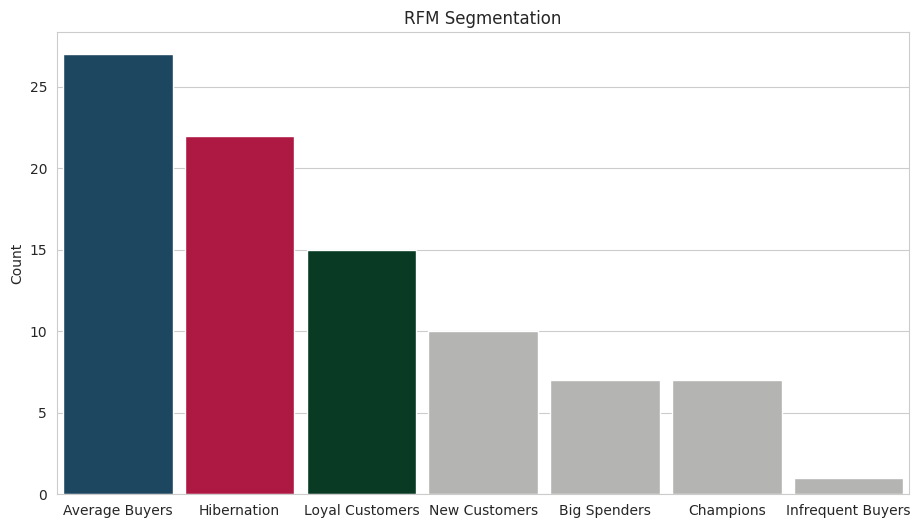

In [ ]:
plt.figure(figsize=(11, 6))
sns.barplot(data = rfm_seg_graph_sorted, x='Segmentation', y='acct_num', palette=['#12486b', '#C70039', '#004225', '#B4B4B3', '#B4B4B3', '#B4B4B3', '#B4B4B3'],
            width=0.9)  # 'x' and 'y' are swapped for horizontal bars
plt.ylabel('Count')
plt.xlabel('')
plt.title('RFM Segmentation')

plt.show()

**Average Buyers**
> Send personalized product recommendations based on their past purchases.
Offer loyalty rewards or discounts to encourage more frequent purchases.

**Hibernation**
> Send reactivation campaigns with special offers or discounts to bring them back.

**Loyal Customers**
> Show appreciation with exclusive offers and early access to new products.
Cross-sell other categories to increase their spend.





# **Step 5: KMeans Clustering of Categories**

In [ ]:
# Extract the hour information and create a new 'hour' column
df_cleaned['hour'] = df_cleaned['transaction_date'].dt.hour

In [ ]:
num_features = ['transaction_amount','hour']
cat_features = ['category']

df_for_clustering = df_cleaned.drop(columns=['cc_num', 'city' ,'gender','city_population', 'job', 'birth_date', 'acct_num', 'transaction_num', 'transaction_date', 'age'])

In [ ]:
df_for_clustering.head()

,transaction_amount,category,age_group,year,month,hour
0,68.88,shopping,NaN,2020,2,5
1,50.06,entertainment,NaN,2020,5,5
2,105.44,food_dining,NaN,2020,3,5
3,38.61,food_dining,NaN,2021,2,17
4,82.69,gas_transport,NaN,2020,9,8


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first'), cat_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', KMeans(n_clusters=4, random_state=42))
])

In [ ]:
pipeline.fit(df_for_clustering)
cluster_labels = pipeline.predict(df_for_clustering)

df_cleaned['Cluster'] = cluster_labels
df_cleaned

,cc_num,acct_num,transaction_date,transaction_num,transaction_amount,category,gender,age,birth_date,job,city,city_population,age_group,year,month,hour,Cluster
0,676000000000.0,798000000000,2020-02-10 05:53:31,a72eaa86b043eed95b25bbb25b3153a1,68.88,shopping,M,64.0,1958-12-12,Chartered loss adjuster,Dasmarinas,659019,NaN,2020,2,5,1
1,3520000000000000.0,968000000000,2020-05-31 05:29:28,060d12f91c13871a13963041736a4702,50.06,entertainment,M,53.0,1970-08-31,"Administrator, charities/voluntary organisations",Digos,169393,NaN,2020,5,5,1
2,4.14e+18,628000000000,2020-03-29 05:52:37,18aafb6098ab0923886c0ac83592ef8d,105.44,food_dining,M,70.0,1953-07-23,Financial controller,Calapan,133893,NaN,2020,3,5,1
3,4870000000000000.0,863000000000,2021-02-11 17:15:04,45bbe714e51ab8a375454d39a190b0cb,38.61,food_dining,M,59.0,1964-07-18,N/A,San Fernando,121812,NaN,2021,2,17,0
4,4720000000000000.0,257000000000,2020-09-28 08:35:59,c20ee88b451f637bc6893b7460e9fee0,82.69,gas_transport,M,68.0,1954-11-01,Dance movement psychotherapist,Laoag,111125,NaN,2020,9,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111870,2470000000000000.0,581000000000,2021-08-05 17:46:09,d44f411eabd406a76a60546e723a98fd,98.23,kids_pets,M,88.0,1935-01-11,"Surveyor, quantity",San Fernando,306659,NaN,2021,8,17,0
111871,3520000000000000.0,531000000000,2021-05-20 03:28:05,7e767a74cae901c13f1a9d1d37aa63d4,78.79,grocery,M,55.0,1967-11-20,Wellsite geologist,Masbate,95389,NaN,2021,5,3,1
111872,4620000000000000.0,555000000000,2021-07-03 19:42:54,6ced184c93e66028e8d235ad3060de90,31.37,personal_care,M,88.0,1934-11-20,Personnel officer,San Fernando,121812,NaN,2021,7,19,0
111874,4430000000000000.0,319000000000,2021-11-14 19:55:58,599d3eec9b385473aa3791b620691416,74.76,home,M,63.0,1960-06-26,N/A,General Santos,594446,NaN,2021,11,19,0


In [ ]:
def kmeans_values(df):

    # Define a custom function to find the top 3 modes
    def custom_mode(series):
        # Use the value_counts() function to count the occurrences of each value
        value_counts = series.value_counts()
        # Sort the value counts in descending order and take the top 3 values
        top_modes = value_counts.head(3)
        # Convert the result to a list
        top_modes_list = top_modes.index.tolist()
        return top_modes_list

    df_new = df.groupby(['Cluster']).agg({
        'acct_num': 'nunique',  # Calculate the unique count of account_num
        'transaction_amount': 'mean',
        'category': custom_mode,
        'transaction_num': 'count',
        'hour': custom_mode
    }).round(0)

    # Calculate the frequency of transactions per person
    df_new['freq_of_transacs_per_person'] = df_new['transaction_num'] / df_new['acct_num']

    return df_new

In [ ]:
kmeans_values(df_cleaned)

,acct_num,transaction_amount,category,transaction_num,hour,freq_of_transacs_per_person
Cluster,,,,,,
0,85,56.0,"[kids_pets, home, personal_care]",39775,"[23, 16, 17]",467.941176
1,88,59.0,"[shopping, grocery, gas_transport]",59040,"[4, 2, 6]",670.909091
2,89,1004.0,"[shopping, misc, N/A]",1176,"[23, 22, 9]",13.213483
3,9,12964.0,[travel],9,"[16, 18, 13]",1.000000


**Cluster 0 Profile & Recommendations**
*   Average Spend: Low
*   Category: Personal Care
*   Time of Day: Evening, Afternoon
*   Frequency: High

> **Bundle Deals:** Create bundle deals as an effective way to encourage clients to make larger purchases especially during night transactions.

> **Category-Based Rewards:** Create special rewards for kids and pets, home, and personal care products.

> **Limited-Time Offers:** Create limited-time offers, such as "double cashback weekends" or "flash sales, to generate excitement and motivate clients to spend especially during night transactions.

------------

**Cluster 1 Profile & Recommendations**
*   Average Spend: Low
*   Category: Home Essentials
*   Time of Day: Morning
*   Frequency: High

> **Morning deals:** Offer special promotions or deals during the early morning hours to attract more customers from this cluster. Consider offering discounts on groceries or gas for their daily commute.

> **Personalized Recommendations:** Use data analytics to provide personalized product recommendations based on their shopping habits to encourage larger transactions.

> **Convenience:** Focus on providing convenience for these customers, such as easy online ordering and quick checkout options.

------------

**Cluster 2 Profile & Recommendations**
*   Average Spend: Medium
*   Category: Non-Essential
*   Time of Day: Evening, Morning
*   Frequency: Low

> **High-End Products:** Since this cluster has significantly higher average spend, consider offering high-end or luxury products that match their spending capacity and to increase spending frequency.

> **Exclusive Events:** Organize exclusive late-night shopping events or limited-time offers for this cluster to entice them to spend more.

------------

**Cluster 3 Profile & Recommendations**
*   Average Spend: High
*   Category: Travel
*   Time of Day: Afternoon, Morning
*   Frequency: Low

> **Travel Packages:** Since this cluster is focused on travel, offer tailored travel packages, discounts on flights, hotels, or vacation packages to cater to their interest.

> **Exclusive Travel Benefits:** Provide exclusive travel benefits or rewards programs for this cluster, such as access to airport lounges, or offer low-fare discounts/events.

> **Search Engine Optimization:** Improve search engine optimization to increase views that would eventually lead to ticket sales.